In [10]:
# Install a pip package in the current Jupyter kernel
import sys
#!{sys.executable} -m pip install mne-connectivity

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import gc
from glob import glob
import numpy as np
import scipy as sp
import statistics, math
import random as rd
import pandas as pd
import dataframe_image as dfi
pd.options.display.float_format = '{:,.2f}'.format

from math import sqrt, ceil

from sklearn import metrics, svm
from sklearn import decomposition, cluster
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, 
                             balanced_accuracy_score, precision_score, recall_score, RocCurveDisplay)
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

from scipy.spatial.distance import correlation
from IPython.display import display

In [4]:
import mne
#import mne_connectivity

from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap, annotate_muscle_zscore, peak_finder,
                               find_eog_events, find_ecg_events, ica_find_ecg_events, find_bad_channels_maxwell)
from mne.time_frequency import (tfr_array_multitaper, psd_array_multitaper, csd_array_multitaper, csd_array_morlet)

from mne_connectivity import seed_target_indices, spectral_connectivity_epochs, spectral_connectivity_time

print(mne.__file__)
print(mne.__version__)

C:\Users\Lenovo\anaconda3\lib\site-packages\mne\__init__.py
1.3.1


In [5]:
import plotly.graph_objects as go
from gtda.time_series import SingleTakensEmbedding, TakensEmbedding, takens_embedding_optimal_parameters
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import BettiCurve, Scaler, Filtering, Amplitude, PersistenceEntropy, NumberOfPoints
from gtda.plotting import plot_point_cloud


In [6]:
# Configure the graphics engine

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.rc('figure', max_open_warning=200)
%matplotlib notebook
#%matplotlib inline
#%matplotlib qt

In [7]:
import seaborn as sns
# Apply the default theme
sns.set_theme()

In [8]:
# My modules
import my_varexplore as ve
import my_dimreduct as dr
import my_clustquality as cq
import my_stageprocess as spr

# Global variables

In [11]:
#==============================================
# Input main data information
#==============================================

# Number of the subject for analysis
SUBJ_NUM = 3

# For m1 and m3 suffix for EEG record number 
SUFFIX = '_2'

# Is surrogate EEG record
#SURR = True


In [12]:
# Initialize path variables for main folders

print(os.getcwd())

if (SUBJ_NUM < 10):
    subj_dir_name = 'm0' + str(SUBJ_NUM) + SUFFIX
else:
    subj_dir_name = 'm' + str(SUBJ_NUM) + SUFFIX

# Add suffix _surr for surrogate data to destination folder
subj_dir_name_surr = subj_dir_name + '_surr'
    
# Path for loading epoch data and features
ft_dir_path = os.path.join(os.getcwd(), 'features', subj_dir_name)
ft_dir_path_surr = os.path.join(os.getcwd(), 'features', subj_dir_name_surr)

print(ft_dir_path)
print(ft_dir_path_surr)

C:\Users\Lenovo\PycharmProjects\Tibet
C:\Users\Lenovo\PycharmProjects\Tibet\features\m03_2
C:\Users\Lenovo\PycharmProjects\Tibet\features\m03_2_surr


In [13]:
# Frequency bands

bands = [(0.9, 4, 'Delta (0.9-4 Hz)', 'D'), (4, 8, 'Theta (4-8 Hz)', 'T'), (8, 14, 'Alpha (8-14 Hz)', 'A'), 
         (14, 25, 'Beta (14-25 Hz)', 'B'), (25, 40, 'Gamma (25-40 Hz)', 'G')]

bands_test = [(0.9, 4, 'Delta (0.9-4 Hz)', 'D'), (4, 7, 'Theta (4-7 Hz)', 'T'), (7, 10, 'Alpha1 (7-10 Hz)','A1'), 
         (10, 13, 'Alpha2 (10-13 Hz)', 'A2'), (13, 20, 'Beta1 (13-20 Hz)', 'B1'), (20, 30, 'Beta2 (20-30 Hz)', 'B2'), 
         (30, 45, 'Gamma (30-45 Hz)', 'G')]

str_freq = [bands[i][3] for i in range(len(bands))]
#str_freq_rr = ['r'+_str for _str in str_freq]
str_freq_rr = str_freq
n_freq = len(str_freq_rr)


In [14]:
# Localization by scalp regions

regions = [(['Fp1','Fp2','Fpz'], 'Fp', 'Pre-frontal'), (['F7','F3','FT7','FC3'], 'LF', 'Left Frontal'), 
           (['Fz','FCz'], 'MF', 'Midline Frontal'), (['F4','F8','FC4','FT8'], 'RF', 'Right Frontal'),
           (['T3','TP7','T5'], 'LT', 'Left Temporal'), (['T4','TP8','T6'], 'RT', 'Right Temporal'), 
           (['C3','CP3'], 'LC', 'Left Central'), (['Cz','CPz'], 'MC', 'Midline Central'), (['C4','CP4'], 'RC', 'Right Central'),
           (['P3','P5'], 'LP', 'Left Parietal'), (['Pz'], 'MP', 'Midline Parietal'), (['P4','P6'], 'RP', 'Right Parietal'), 
           (['PO3','PO7','O1'], 'LO', 'Left Occipital'), (['POz','Oz'], 'MO', 'Midline Occipital'), 
           (['PO4','PO8','O2'], 'RO', 'Right Occipital')]
regions_plt = [(['Fp1','Fp2','Fpz'], 'Fp', 'Pre-frontal', ['Fp']), (['F7','F3','FT7','FC3'], 'LF', 'Left Frontal', ['LF']), 
               (['Fz','FCz'], 'MF', 'Midline Frontal', ['MF']), (['F4','F8','FC4','FT8'], 'RF', 'Right Frontal', ['RF']),
               (['T3','TP7','T5'], 'LT', 'Left Temporal', ['LT']), (['T4','TP8','T6'], 'RT', 'Right Temporal', ['RT']), 
               (['C3','CP3','Cz','CPz','C4','CP4'], 'Cen', 'Central', ['LC','MC','RC']), 
               (['P3','P5','Pz','P4','P6'], 'Par', 'Parietal', ['LP','MP','RP']), 
               (['PO3','PO7','O1','POz','Oz','PO4','PO8','O2'], 'Occ', 'Occipital', ['LO','MO','RO'])]

n_regions = len(regions)
n_regions_plt = len(regions_plt)



# Loading data

In [54]:
# Loading epochs (Meditator data)

epochs_filt_rr = mne.read_epochs(os.path.join(ft_dir_path, 'epochs_filt_rr-epo.fif'))
print(epochs_filt_rr.get_data().shape)

sampling_rate = epochs_filt_rr.info['sfreq']
n_samples = epochs_filt_rr.__len__()
n_times = len(epochs_filt_rr.get_data()[0,0,:])

ch_names = epochs_filt_rr.ch_names
n_channels = len(ch_names)
print(ch_names)

Reading C:\Users\Lenovo\PycharmProjects\Tibet\features\m03_2\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1180 matching events found
No baseline correction applied
0 projection items activated
(1180, 40, 501)
['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FT7', 'FC3', 'FCz', 'FC4', 'FT8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'A1', 'T5', 'P3', 'Pz', 'P4', 'T6', 'A2', 'P5', 'PO3', 'POz', 'PO4', 'P6', 'PO7', 'O1', 'Oz', 'O2', 'PO8']


In [55]:
# Loading main features DataFrames

df_ft_psd_loc_db = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_psd_loc_db.feather'))
df_ft_psd_plt_db = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_psd_plt_db.feather'))
df_ft_psd_all_db = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_psd_all_db.feather'))
df_ft_psd_ind_loc_log = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_psd_ind_loc_log.feather'))
df_ft_psd_ind_plt_log = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_psd_ind_plt_log.feather'))
df_ft_psd_ind_all_log = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_psd_ind_all_log.feather'))

#df_ft_coh = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_coh.feather'))
#df_ft_plv = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_plv.feather'))
df_ft_coh_loc = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_coh_loc.feather'))
df_ft_plv_loc = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_plv_loc.feather'))
df_ft_coh_plt = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_coh_plt.feather'))
df_ft_plv_plt = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_plv_plt.feather'))

df_ft_coh_ind_loc = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_coh_ind_loc.feather'))
df_ft_plv_ind_loc = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_plv_ind_loc.feather'))
df_ft_coh_ind_plt = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_coh_ind_plt.feather'))
df_ft_plv_ind_plt = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_plv_ind_plt.feather'))
df_ft_coh_ind_all = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_coh_ind_all.feather'))
df_ft_plv_ind_all = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_plv_ind_all.feather'))

In [56]:
# Scaling features data

# PSD & PSD indices
ft_psd_loc_db_sc = StandardScaler().fit_transform(df_ft_psd_loc_db.to_numpy())
df_ft_psd_loc_db_sc = pd.DataFrame(ft_psd_loc_db_sc, columns=df_ft_psd_loc_db.columns)
ft_psd_all_db_sc = StandardScaler().fit_transform(df_ft_psd_all_db.to_numpy())
df_ft_psd_all_db_sc = pd.DataFrame(ft_psd_all_db_sc, columns=df_ft_psd_all_db.columns)

ft_psd_ind_loc_sc = StandardScaler().fit_transform(df_ft_psd_ind_loc_log.to_numpy())
df_ft_psd_ind_loc_sc = pd.DataFrame(ft_psd_ind_loc_sc, columns=df_ft_psd_ind_loc_log.columns)
ft_psd_ind_all_sc = StandardScaler().fit_transform(df_ft_psd_ind_all_log.to_numpy())
df_ft_psd_ind_all_sc = pd.DataFrame(ft_psd_ind_all_sc, columns=df_ft_psd_ind_all_log.columns)

# Coherence indices
ft_coh_ind_loc_sc = StandardScaler().fit_transform(df_ft_coh_ind_loc.to_numpy())
df_ft_coh_ind_loc_sc = pd.DataFrame(ft_coh_ind_loc_sc, columns=df_ft_coh_ind_loc.columns)

# PLV indices
ft_plv_ind_loc_sc = StandardScaler().fit_transform(df_ft_plv_ind_loc.to_numpy())
df_ft_plv_ind_loc_sc = pd.DataFrame(ft_plv_ind_loc_sc, columns=df_ft_plv_ind_loc.columns)


<IPython.core.display.Javascript object>


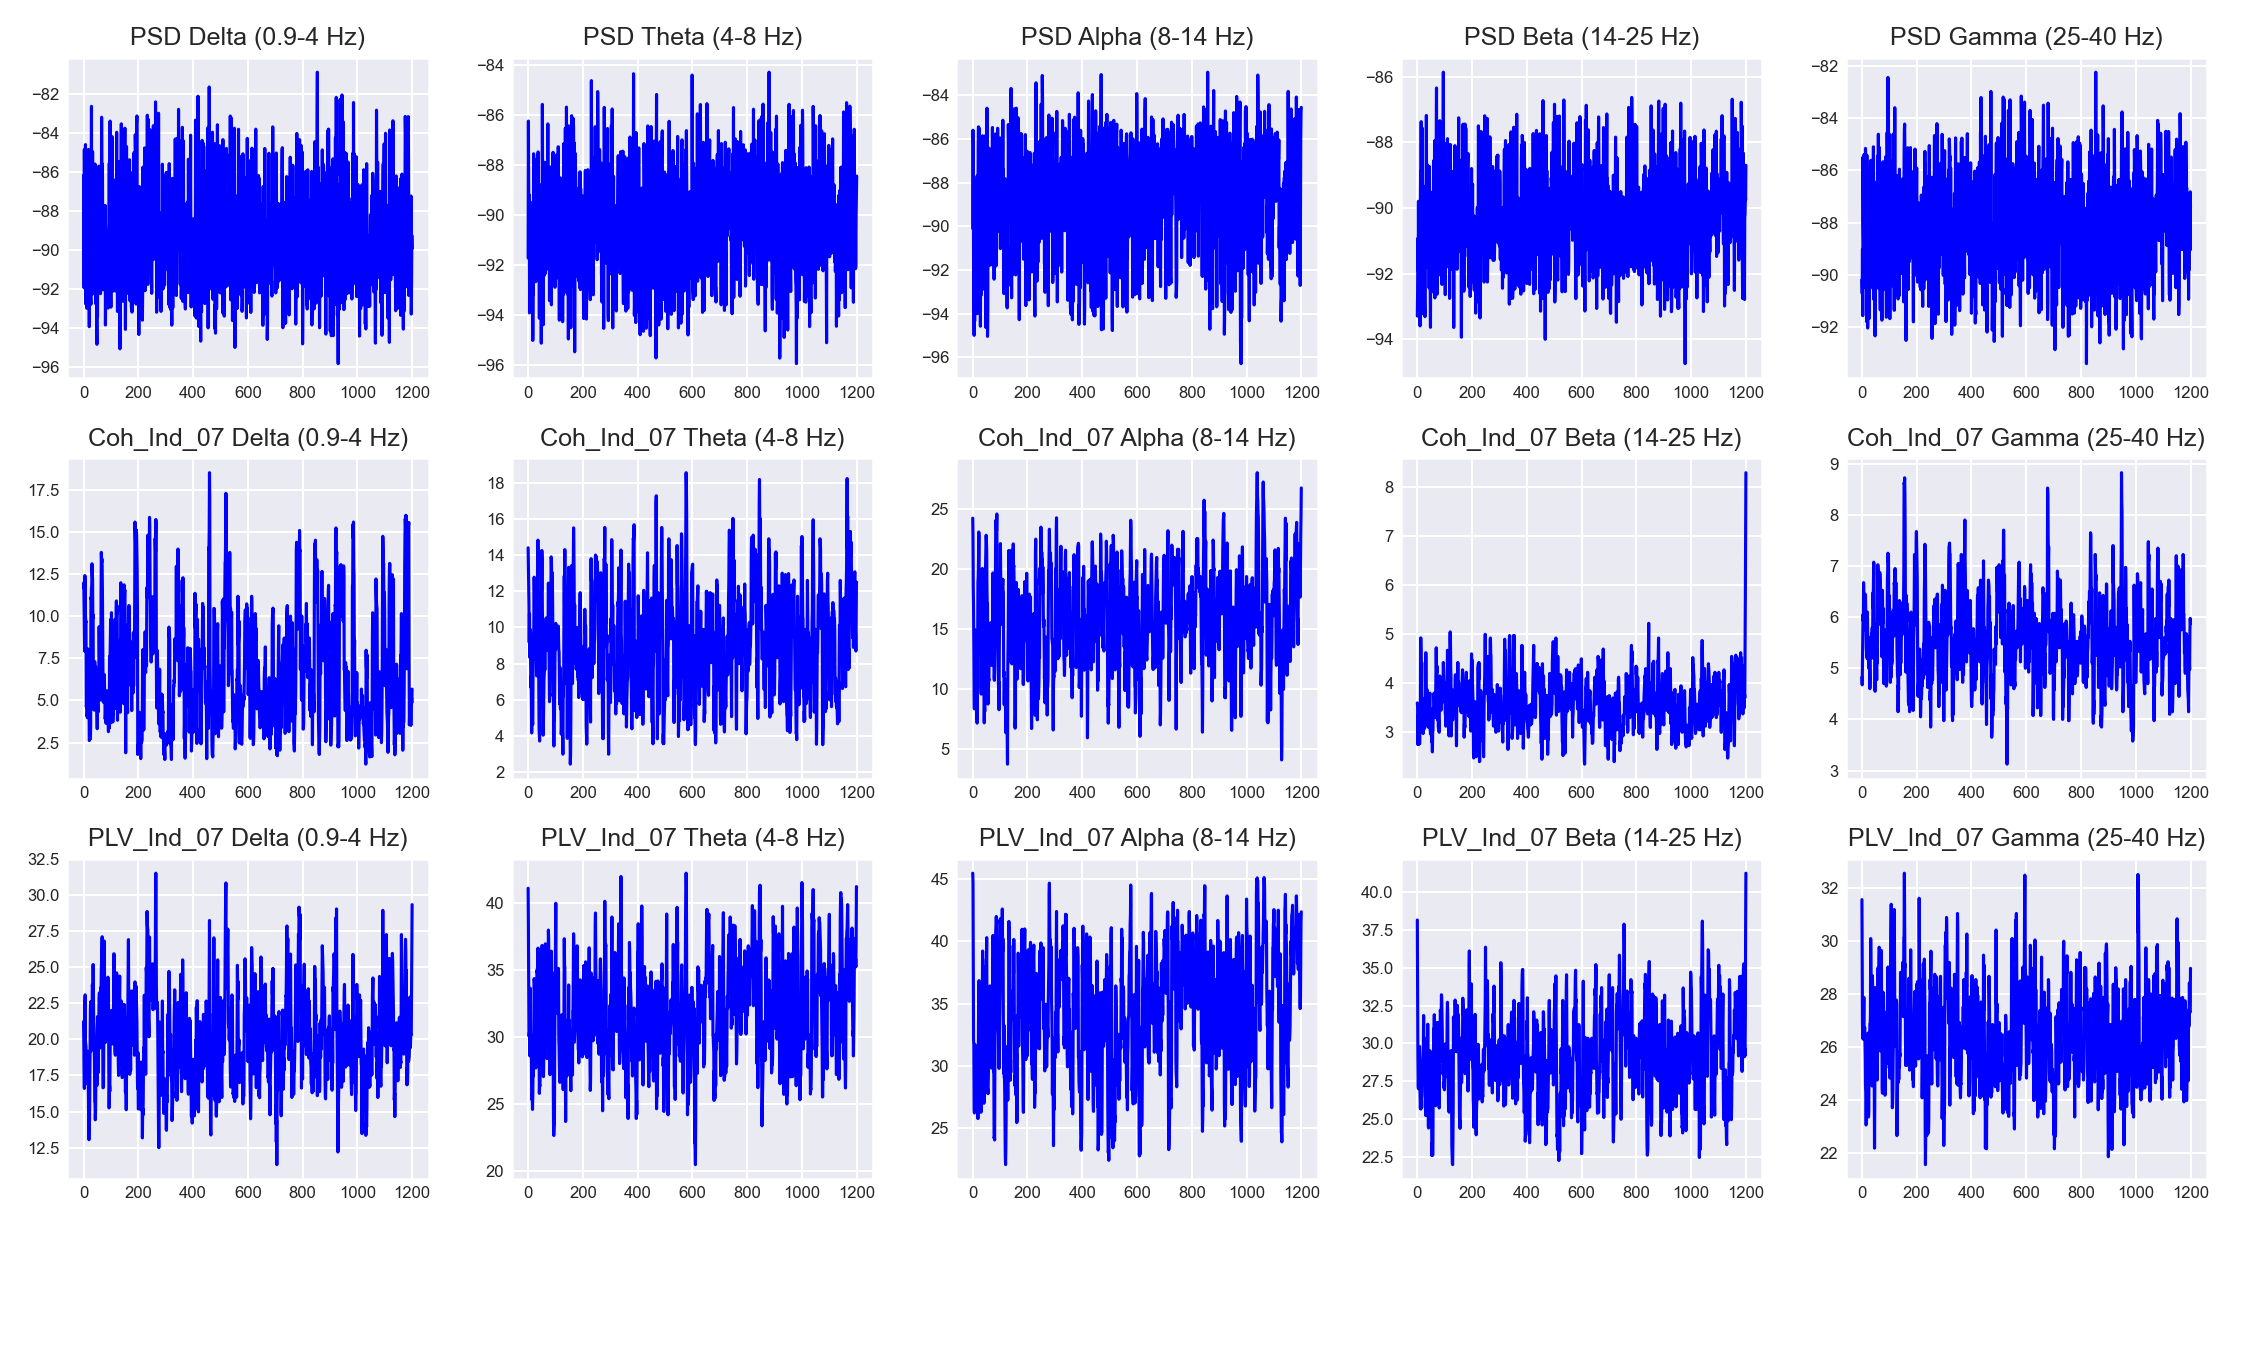

In [44]:
# Plotting overall PSD, Coherence and PLV with stage bounds

ind_rate = '07'

# Features DataFrames
df_ft_psd = df_ft_psd_all_db
df_cols = [col for col in df_ft_coh_ind_all.columns if (ind_rate in col)]
df_ft_coh = df_ft_coh_ind_all[df_cols]
df_cols = [col for col in df_ft_plv_ind_all.columns if (ind_rate in col)]
df_ft_plv = df_ft_plv_ind_all[df_cols]

# Initialize plots
n_cols = n_freq
n_rows = 3
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))
plt.subplots_adjust(left=0.02)

# PSD plots (1st row)
for i in range(n_freq):
    y = df_ft_psd.to_numpy()[:,i]  
    axs[0,i].plot(y, color='blue')
    axs[0,i].set_title("PSD "+ bands[i][2])
    axs[0,i].tick_params(axis='both', labelsize=8, direction='in')
       
# Coherence plots (2nd row)
for i in range(n_freq):
    y = df_ft_coh.to_numpy()[:,i]
    axs[1,i].plot(y, color='blue')
    axs[1,i].set_title('Coh_Ind_'+ind_rate+' '+bands[i][2])
    axs[1,i].tick_params(axis='both', labelsize=8, direction='in')
    
# PLV plots (3rd row)
for i in range(n_freq):
    y = df_ft_plv.to_numpy()[:,i]
    axs[2,i].plot(y, color='blue')
    axs[2,i].set_title('PLV_Ind_'+ind_rate+' '+bands[i][2])
    axs[2,i].tick_params(axis='both', labelsize=8, direction='in')
    
plt.tight_layout(rect=[0,0.09,1,1])


# Clusterization functions

In [22]:
# Функция для расчёта оценок качетва кластеризации
def cluster_metrics_noground(name, data, labels_pred):
    results = [name]
    df_data = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])

    # Define the metrics which require only data and predicted labels
    cluster_metrics = [
        metrics.silhouette_score,
        metrics.calinski_harabasz_score,
        metrics.davies_bouldin_score
    ]
    results += [m(data, labels_pred) for m in cluster_metrics]

    df_data.loc[0] = results
    
    return df_data

In [23]:
def apply_cluster_method(data, cl_method, name, df_metrics, **kwargs):
    method = cl_method(**kwargs).fit(data)
    
    df = cluster_metrics_noground(name, data, method.labels_)
    df_metrics = df_metrics.drop(df_metrics[df_metrics['Method']==name].index, errors='ignore')
    df_metrics = pd.concat([df_metrics, df], ignore_index=True)
    
    return method, df_metrics

In [24]:
# Calculating clustering noground metrics for adjacent pairs of stages (Silh, Cal-Har, Dav-Bold)
def calc_stage_metr_noground(df_features, st_edges):
    df_metrics = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
    
    for _st in range(1, len(st_edges)-1):
        name = 'St'+str(_st)+'_St'+str(_st+1)
        data = df_features.iloc[st_edges[_st-1]:st_edges[_st+1]].reset_index(drop=True)
        labels = [0 for i in range(st_edges[_st]-st_edges[_st-1])] + [1 for i in range(st_edges[_st+1]-st_edges[_st])]
        
        df = cq.cluster_metrics_noground(name, data, labels)
        df_metrics = df_metrics.drop(df_metrics[df_metrics['Method']==name].index, errors='ignore')
        df_metrics = pd.concat([df_metrics, df], ignore_index=True)
    
    df_metrics.rename(columns={'Method': 'Stages'}, inplace=True)

    return df_metrics


In [25]:
# Матрица связности для k соседних по времени эпох
#K_NEIGHBORS = 30

def knn_con_matr(X):
    n_samples = len(X)
    sm = sp.sparse.lil_matrix((n_samples, n_samples), dtype=np.int8)
    for i in range(n_samples):
        for j in range(n_samples):
            if abs(i-j)<=k_neighbours: sm[i,j]=1
    return sm.tocsr()


## Clustering process

In [57]:
display(df_ft_psd_loc_db_sc.describe())
display(df_ft_psd_ind_loc_sc.describe())
display(df_ft_coh_ind_loc_sc.describe())
display(df_ft_plv_ind_loc_sc.describe())

D_psd_Fp  D_psd_LF  D_psd_MF  D_psd_RF  D_psd_LT  D_psd_RT  D_psd_LC  \
count  1,180.00  1,180.00  1,180.00  1,180.00  1,180.00  1,180.00  1,180.00   
mean      -0.00     -0.00     -0.00      0.00      0.00     -0.00     -0.00   
std        1.00      1.00      1.00      1.00      1.00      1.00      1.00   
min       -2.46     -2.06     -2.60     -2.20     -2.73     -2.31     -2.58   
25%       -0.72     -0.75     -0.74     -0.70     -0.71     -0.74     -0.70   
50%       -0.13     -0.19     -0.13     -0.14     -0.11     -0.15     -0.16   
75%        0.63      0.67      0.64      0.54      0.61      0.63      0.56   
max        5.64      3.73      3.70      4.29      3.63      3.81      3.04   

       D_psd_MC  D_psd_RC  D_psd_LP  ...  G_psd_RT  G_psd_LC  G_psd_MC  \
count  1,180.00  1,180.00  1,180.00  ...  1,180.00  1,180.00  1,180.00   
mean       0.00      0.00     -0.00  ...     -0.00     -0.00     -0.00   
std        1.00      1.00      1.00  ...      1.00      1.00      1.00   
min       -2.42     -2.55     -2.86  ...     -2.91     -2.48     -2.73   
25%       -0.72     -0.73     -0.70  ...     -0.48     -0.82     -0.78   
50%       -0.16     -0.09     -0.10  ...      0.02      0.05     -0.08   
75%        0.59      0.64      0.64  ...      0.53      0.77      0.76   
max        3.18      3.07      3.69  ...      5.69      3.02      3.03   

       G_psd_RC  G_psd_LP  G_psd_MP  G_psd_RP  G_psd_LO  G_psd_MO  G_psd_RO  
count  1,180.00  1,180.00  1,180.00  1,180.00  1,180.00  1,180.00  1,180.00  
mean      -0.00     -0.00     -0.00     -0.00     -0.00     -0.00      0.00  
std        1.00      1.00      1.00      1.00      1.00      1.00      1.00  
min       -2.07     -2.67     -3.31     -2.07     -2.82     -3.64     -2.64  
25%       -0.86     -0.79     -0.66     -0.84     -0.70     -0.63     -0.76  
50%       -0.01      0.03     -0.00     -0.11     -0.09     -0.03     -0.14  
75%        0.78      0.73      0.66      0.76      0.65      0.57      0.63  
max        5.49      2.89      3.24      2.90      3.32      5.31      3.64  

[8 rows x 75 columns]

T_D_psd_Fp  A_D_psd_Fp  A_T_psd_Fp  A_DT_psd_Fp  B_D_psd_Fp  \
count    1,180.00    1,180.00    1,180.00     1,180.00    1,180.00   
mean        -0.00       -0.00       -0.00         0.00       -0.00   
std          1.00        1.00        1.00         1.00        1.00   
min         -3.49       -4.61       -4.01        -5.78       -4.99   
25%         -0.70       -0.63       -0.65        -0.57       -0.64   
50%          0.11        0.07       -0.03         0.14        0.04   
75%          0.72        0.73        0.60         0.69        0.68   
max          2.55        2.26        3.80         2.64        3.52   

       B_T_psd_Fp  B_A_psd_Fp  B_DT_psd_Fp  B_TA_psd_Fp  G_D_psd_Fp  ...  \
count    1,180.00    1,180.00     1,180.00     1,180.00    1,180.00  ...   
mean         0.00        0.00        -0.00        -0.00        0.00  ...   
std          1.00        1.00         1.00         1.00        1.00  ...   
min         -3.73       -3.41        -5.64        -3.78       -4.67  ...   
25%         -0.69       -0.70        -0.63        -0.68       -0.66  ...   
50%          0.04       -0.00         0.04         0.06        0.03  ...   
75%          0.69        0.70         0.70         0.72        0.71  ...   
max          3.12        2.71         3.73         2.67        2.87  ...   

       B_A_psd_RO  B_DT_psd_RO  B_TA_psd_RO  G_D_psd_RO  G_T_psd_RO  \
count    1,180.00     1,180.00     1,180.00    1,180.00    1,180.00   
mean         0.00        -0.00         0.00       -0.00        0.00   
std          1.00         1.00         1.00        1.00        1.00   
min         -2.06        -3.30        -2.28       -3.08       -2.33   
25%         -0.75        -0.64        -0.78       -0.69       -0.78   
50%         -0.24        -0.01        -0.17       -0.00       -0.09   
75%          0.64         0.64         0.69        0.69        0.73   
max          2.74         2.85         2.77        3.30        3.29   

       G_A_psd_RO  G_B_psd_RO  G_DT_psd_RO  G_TA_psd_RO  G_AB_psd_RO  
count    1,180.00    1,180.00     1,180.00     1,180.00     1,180.00  
mean        -0.00        0.00        -0.00        -0.00         0.00  
std          1.00        1.00         1.00         1.00         1.00  
min         -1.87       -3.23        -2.79        -2.10        -2.05  
25%         -0.77       -0.76        -0.71        -0.78        -0.78  
50%         -0.24        0.01        -0.10        -0.18        -0.18  
75%          0.66        0.70         0.62         0.75         0.76  
max          2.87        2.76         3.02         2.87         2.63  

[8 rows x 240 columns]

D_coh_Fp_06  D_coh_Fp_07  D_coh_Fp_08  D_coh_LF_06  D_coh_LF_07  \
count     1,180.00     1,180.00     1,180.00     1,180.00     1,180.00   
mean         -0.00        -0.00         0.00        -0.00         0.00   
std           1.00         1.00         1.00         1.00         1.00   
min          -1.63        -1.16        -0.81        -1.85        -1.38   
25%          -0.80        -0.66        -0.47        -0.75        -0.73   
50%          -0.16        -0.29        -0.30        -0.23        -0.28   
75%           0.55         0.40         0.21         0.65         0.52   
max           4.20         4.72         5.84         3.62         4.35   

       D_coh_LF_08  D_coh_MF_06  D_coh_MF_07  D_coh_MF_08  D_coh_RF_06  ...  \
count     1,180.00     1,180.00     1,180.00     1,180.00     1,180.00  ...   
mean          0.00        -0.00         0.00        -0.00         0.00  ...   
std           1.00         1.00         1.00         1.00         1.00  ...   
min          -1.03        -2.16        -1.56        -1.06        -1.45  ...   
25%          -0.67        -0.73        -0.76        -0.69        -0.67  ...   
50%          -0.30        -0.09        -0.22        -0.31        -0.25  ...   
75%           0.35         0.63         0.67         0.44         0.34  ...   
max           5.70         3.18         3.71         5.19         4.75  ...   

       G_coh_RP_08  G_coh_LO_06  G_coh_LO_07  G_coh_LO_08  G_coh_MO_06  \
count     1,180.00     1,180.00     1,180.00     1,180.00     1,180.00   
mean         -0.00         0.00         0.00        -0.00        -0.00   
std           1.00         1.00         1.00         1.00         1.00   
min          -2.19        -2.67        -2.47        -1.68        -4.11   
25%          -0.88        -0.76        -0.33        -0.42         0.06   
50%           0.11        -0.04        -0.02        -0.42         0.06   
75%           1.09         0.67         0.59         1.25         0.48   
max           3.05         3.78         3.65         3.77         4.23   

       G_coh_MO_07  G_coh_MO_08  G_coh_RO_06  G_coh_RO_07  G_coh_RO_08  
count     1,180.00     1,180.00     1,180.00     1,180.00     1,180.00  
mean         -0.00        -0.00        -0.00        -0.00         0.00  
std           1.00         1.00         1.00         1.00         1.00  
min          -2.50        -3.37        -1.66        -1.96        -1.67  
25%          -0.94        -0.89        -0.68        -0.34        -0.24  
50%          -0.15        -0.06        -0.19        -0.34        -0.24  
75%           0.89         0.77         0.55         0.31         0.23  
max           1.94         4.91         3.98         4.20         5.47  

[8 rows x 225 columns]

D_plv_Fp_06  D_plv_Fp_07  D_plv_Fp_08  D_plv_LF_06  D_plv_LF_07  \
count     1,180.00     1,180.00     1,180.00     1,180.00     1,180.00   
mean         -0.00        -0.00         0.00         0.00        -0.00   
std           1.00         1.00         1.00         1.00         1.00   
min          -3.52        -3.22        -2.75        -3.20        -2.53   
25%          -0.67        -0.67        -0.63        -0.72        -0.72   
50%          -0.05        -0.12        -0.14        -0.02        -0.08   
75%           0.64         0.57         0.51         0.62         0.56   
max           3.55         4.02         4.52         3.36         3.71   

       D_plv_LF_08  D_plv_MF_06  D_plv_MF_07  D_plv_MF_08  D_plv_RF_06  ...  \
count     1,180.00     1,180.00     1,180.00     1,180.00     1,180.00  ...   
mean          0.00        -0.00         0.00         0.00         0.00  ...   
std           1.00         1.00         1.00         1.00         1.00  ...   
min          -2.34        -3.34        -3.02        -2.59        -2.47  ...   
25%          -0.73        -0.63        -0.70        -0.72        -0.73  ...   
50%          -0.10        -0.09        -0.00        -0.03        -0.08  ...   
75%           0.53         0.67         0.60         0.56         0.57  ...   
max           4.08         2.94         3.12         3.41         3.39  ...   

       G_plv_RP_08  G_plv_LO_06  G_plv_LO_07  G_plv_LO_08  G_plv_MO_06  \
count     1,180.00     1,180.00     1,180.00     1,180.00     1,180.00   
mean         -0.00         0.00         0.00         0.00         0.00   
std           1.00         1.00         1.00         1.00         1.00   
min          -3.00        -2.94        -2.63        -2.40        -2.81   
25%          -0.71        -0.71        -0.69        -0.67        -0.76   
50%          -0.01        -0.00        -0.08        -0.02        -0.02   
75%           0.70         0.71         0.63         0.63         0.72   
max           2.63         3.14         3.49         3.77         2.95   

       G_plv_MO_07  G_plv_MO_08  G_plv_RO_06  G_plv_RO_07  G_plv_RO_08  
count     1,180.00     1,180.00     1,180.00     1,180.00     1,180.00  
mean         -0.00        -0.00        -0.00        -0.00        -0.00  
std           1.00         1.00         1.00         1.00         1.00  
min          -2.47        -2.22        -2.85        -2.45        -2.27  
25%          -0.73        -0.79        -0.72        -0.62        -0.67  
50%          -0.08        -0.12        -0.03        -0.09        -0.06  
75%           0.65         0.65         0.65         0.54         0.54  
max           3.31         4.19         3.04         3.41         3.85  

[8 rows x 225 columns]

In [58]:
# PCA decomposition

# Number of PCA compnents
#N_COMP = 0.7
N_COMP = 15

df_ft_tot_orig = pd.concat([df_ft_psd_loc_db_sc, df_ft_psd_ind_loc_sc, df_ft_coh_ind_loc_sc, df_ft_plv_ind_loc_sc], axis=1)
#df_ft_tot_orig = pd.concat([df_ft_psd_loc_db_sc, df_ft_psd_ind_loc_sc], axis=1)
n_features = len(df_ft_tot_orig.columns)

pca = decomposition.PCA(n_components=N_COMP)

ft_tot_pca = pca.fit_transform(df_ft_tot_orig)
print(ft_tot_pca.shape)
print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
print([round(x,3) for x in pca.explained_variance_ratio_])


n_pca_comps = len(ft_tot_pca[0,:])
pca_comp_names = ['PCA_'+str(i) for i in range(n_pca_comps)]
#print(n_pca_comps)
print(n_features)
print(n_samples)

df_ft_tot_pca = pd.DataFrame(ft_tot_pca, columns=pca_comp_names)
#df_ft_tot_pca = pd.DataFrame(ft_tot_pca[:-2], columns=pca_comp_names) # for m8
n_samples = len(df_ft_tot_pca)
print(n_samples, df_ft_tot_pca.to_numpy().shape)

(1180, 15)
Explained variance 0.72
[0.323, 0.095, 0.07, 0.043, 0.032, 0.025, 0.023, 0.02, 0.018, 0.016, 0.014, 0.012, 0.011, 0.01, 0.009]
765
1180
1180 (1180, 15)


In [59]:
# Iterative automatic process of finding best clusterisation 

# Global variables
k_neighb_min = 20
k_neighb_max = 50
n_cl_min = 2
n_cl_max = 20

len_st_thr = [0, 20, 40, 60] # stage length thresholds for staging process

st_dist_rate = 0.3

#min_stage_length = 40 # minimum acceptable stage length

# Initialization
df_features = df_ft_tot_pca
print(len(df_features.columns))

df_best_metrics = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
df_st_edges = pd.DataFrame(columns=['Len_min', 'N_clusters', 'K_neighb', 'Silh', 'St_edges'])

for n_clusters in range(n_cl_min, n_cl_max+1):
    for k_neighbours in range(k_neighb_min, k_neighb_max+1):
        # Clustering, Ward method        
        cl_name = 'ward_pca_'+str(n_clusters)+'_'+str(k_neighbours)
        cl_method, df_best_metrics = apply_cluster_method(data=df_features, cl_method=AgglomerativeClustering, 
                                                          name=cl_name, df_metrics=df_best_metrics, n_clusters=n_clusters, 
                                                          linkage='ward', connectivity=knn_con_matr)
        # Forming stages from clusters
        st_edges = spr.form_stages(cl_method.labels_)
        
        # Merging stages
        for st_len_min in len_st_thr:
            st_edges = spr.merge_stages_1st_step(df_features, st_edges, len_threshold=st_len_min) 
            st_edges = spr.merge_stages_2nd_step(df_features, st_edges, dist_threshold=st_dist_rate) 
            # Insert clusterization results into DataFrame
            silh_metric = df_best_metrics[df_best_metrics['Method']==cl_name].iloc[0]['Silh']
            new_row = {'Len_min': st_len_min, 'N_clusters': n_clusters, 'K_neighb': k_neighbours, 
                                       'Silh': silh_metric, 'St_edges': st_edges}
            df_st_edges = df_st_edges.append(new_row, ignore_index = True)
            # Print results
            st_lengths = np.array([st_edges[i+1] - st_edges[i] for i in range(len(st_edges)-1)])
            print(st_len_min, n_clusters, k_neighbours, len(st_lengths), st_edges, st_lengths)

display(df_best_metrics)
display(df_st_edges)

15
0 2 20 2 [   0  897 1180] [897 283]
20 2 20 2 [   0  897 1180] [897 283]
40 2 20 2 [   0  897 1180] [897 283]
60 2 20 2 [   0  897 1180] [897 283]
0 2 21 3 [   0  685  855 1180] [685 170 325]
20 2 21 3 [   0  685  855 1180] [685 170 325]
40 2 21 3 [   0  685  855 1180] [685 170 325]
60 2 21 3 [   0  685  855 1180] [685 170 325]
0 2 22 2 [   0  897 1180] [897 283]
20 2 22 2 [   0  897 1180] [897 283]
40 2 22 2 [   0  897 1180] [897 283]
60 2 22 2 [   0  897 1180] [897 283]
0 2 23 2 [   0  897 1180] [897 283]
20 2 23 2 [   0  897 1180] [897 283]
40 2 23 2 [   0  897 1180] [897 283]
60 2 23 2 [   0  897 1180] [897 283]
0 2 24 2 [   0  685 1180] [685 495]
20 2 24 2 [   0  685 1180] [685 495]
40 2 24 2 [   0  685 1180] [685 495]
60 2 24 2 [   0  685 1180] [685 495]
0 2 25 2 [   0  685 1180] [685 495]
20 2 25 2 [   0  685 1180] [685 495]
40 2 25 2 [   0  685 1180] [685 495]
60 2 25 2 [   0  685 1180] [685 495]
0 2 26 3 [   0  585  729 1180] [585 144 451]
20 2 26 3 [   0  585  729 1180] [5

0 3 36 5 [   0  192  314  458  938 1180] [192 122 144 480 242]
20 3 36 5 [   0  192  314  458  938 1180] [192 122 144 480 242]
40 3 36 5 [   0  192  314  458  938 1180] [192 122 144 480 242]
60 3 36 5 [   0  192  314  458  938 1180] [192 122 144 480 242]
0 3 37 4 [   0  189  514  938 1180] [189 325 424 242]
20 3 37 4 [   0  189  514  938 1180] [189 325 424 242]
40 3 37 4 [   0  189  514  938 1180] [189 325 424 242]
60 3 37 4 [   0  189  514  938 1180] [189 325 424 242]
0 3 38 4 [   0  189  514  938 1180] [189 325 424 242]
20 3 38 4 [   0  189  514  938 1180] [189 325 424 242]
40 3 38 4 [   0  189  514  938 1180] [189 325 424 242]
60 3 38 4 [   0  189  514  938 1180] [189 325 424 242]
0 3 39 4 [   0  189  458  928 1180] [189 269 470 252]
20 3 39 4 [   0  189  458  928 1180] [189 269 470 252]
40 3 39 4 [   0  189  458  928 1180] [189 269 470 252]
60 3 39 4 [   0  189  458  928 1180] [189 269 470 252]
0 3 40 4 [   0  189  670  783 1180] [189 481 113 397]
20 3 40 4 [   0  189  670  783 118

0 4 39 5 [   0  189  458  783  928 1180] [189 269 325 145 252]
20 4 39 5 [   0  189  458  783  928 1180] [189 269 325 145 252]
40 4 39 5 [   0  189  458  783  928 1180] [189 269 325 145 252]
60 4 39 5 [   0  189  458  783  928 1180] [189 269 325 145 252]
0 4 40 5 [   0  189  528  670  783 1180] [189 339 142 113 397]
20 4 40 5 [   0  189  528  670  783 1180] [189 339 142 113 397]
40 4 40 5 [   0  189  528  670  783 1180] [189 339 142 113 397]
60 4 40 5 [   0  189  528  670  783 1180] [189 339 142 113 397]
0 4 41 5 [   0  189  528  670  783 1180] [189 339 142 113 397]
20 4 41 5 [   0  189  528  670  783 1180] [189 339 142 113 397]
40 4 41 5 [   0  189  528  670  783 1180] [189 339 142 113 397]
60 4 41 5 [   0  189  528  670  783 1180] [189 339 142 113 397]
0 4 42 5 [   0  189  261  670  783 1180] [189  72 409 113 397]
20 4 42 5 [   0  189  261  670  783 1180] [189  72 409 113 397]
40 4 42 5 [   0  189  261  670  783 1180] [189  72 409 113 397]
60 4 42 5 [   0  189  261  670  783 1180] [1

0 5 38 7 [   0  189  268  514  670  783  938 1180] [189  79 246 156 113 155 242]
20 5 38 7 [   0  189  268  514  670  783  938 1180] [189  79 246 156 113 155 242]
40 5 38 7 [   0  189  268  514  670  783  938 1180] [189  79 246 156 113 155 242]
60 5 38 7 [   0  189  268  514  670  783  938 1180] [189  79 246 156 113 155 242]
0 5 39 8 [   0  189  407  458  644  725  783  928 1180] [189 218  51 186  81  58 145 252]
20 5 39 8 [   0  189  407  458  644  725  783  928 1180] [189 218  51 186  81  58 145 252]
40 5 39 8 [   0  189  407  458  644  725  783  928 1180] [189 218  51 186  81  58 145 252]
60 5 39 6 [   0  189  458  644  783  928 1180] [189 269 186 139 145 252]
0 5 40 8 [   0   13  189  261  528  670  783 1120 1180] [ 13 176  72 267 142 113 337  60]
20 5 40 7 [   0  189  261  528  670  783 1120 1180] [189  72 267 142 113 337  60]
40 5 40 7 [   0  189  261  528  670  783 1120 1180] [189  72 267 142 113 337  60]
60 5 40 6 [   0  189  261  528  670  783 1180] [189  72 267 142 113 397]
0

0 6 33 8 [   0   13  175  268  510  632  743  783 1180] [ 13 162  93 242 122 111  40 397]
20 6 33 7 [   0  175  268  510  632  743  783 1180] [175  93 242 122 111  40 397]
40 6 33 6 [   0  175  268  510  632  783 1180] [175  93 242 122 151 397]
60 6 33 6 [   0  175  268  510  632  783 1180] [175  93 242 122 151 397]
0 6 34 9 [   0   13  268  314  510  670  743  827  938 1180] [ 13 255  46 196 160  73  84 111 242]
20 6 34 8 [   0  268  314  510  670  743  827  938 1180] [268  46 196 160  73  84 111 242]
40 6 34 8 [   0  268  314  510  670  743  827  938 1180] [268  46 196 160  73  84 111 242]
60 6 34 6 [   0  268  510  670  827  938 1180] [268 242 160 157 111 242]
0 6 35 9 [   0   13  192  261  314  622  670  783  938 1180] [ 13 179  69  53 308  48 113 155 242]
20 6 35 8 [   0  192  261  314  622  670  783  938 1180] [192  69  53 308  48 113 155 242]
40 6 35 8 [   0  192  261  314  622  670  783  938 1180] [192  69  53 308  48 113 155 242]
60 6 35 6 [   0  192  314  622  783  938 1180] 

0 7 26 11 [   0   13  175  201  314  585  633  729  783  938 1126 1180] [ 13 162  26 113 271  48  96  54 155 188  54]
20 7 26 10 [   0  175  201  314  585  633  729  783  938 1126 1180] [175  26 113 271  48  96  54 155 188  54]
40 7 26 9 [   0  201  314  585  633  729  783  938 1126 1180] [201 113 271  48  96  54 155 188  54]
60 7 26 6 [   0  201  314  585  729  938 1180] [201 113 271 144 209 242]
0 7 27 11 [   0   13  175  190  314  458  488  633  685  729 1166 1180] [ 13 162  15 124 144  30 145  52  44 437  14]
20 7 27 6 [   0  190  314  458  633  729 1180] [190 124 144 175  96 451]
40 7 27 6 [   0  190  314  458  633  729 1180] [190 124 144 175  96 451]
60 7 27 6 [   0  190  314  458  633  729 1180] [190 124 144 175  96 451]
0 7 28 11 [   0   13  133  175  201  314  458  632  685  745 1166 1180] [ 13 120  42  26 113 144 174  53  60 421  14]
20 7 28 9 [   0  133  175  201  314  458  632  685  745 1180] [133  42  26 113 144 174  53  60 435]
40 7 28 8 [   0  133  175  314  458  632  68

0 7 49 8 [   0    6  189  270  670  743  783  928 1180] [  6 183  81 400  73  40 145 252]
20 7 49 7 [   0  189  270  670  743  783  928 1180] [189  81 400  73  40 145 252]
40 7 49 6 [   0  189  270  670  783  928 1180] [189  81 400 113 145 252]
60 7 49 6 [   0  189  270  670  783  928 1180] [189  81 400 113 145 252]
0 7 50 11 [   0    6  190  261  354  514  670  690  783  928  960 1180] [  6 184  71  93 160 156  20  93 145  32 220]
20 7 50 7 [   0  190  261  514  670  783  928 1180] [190  71 253 156 113 145 252]
40 7 50 7 [   0  190  261  514  670  783  928 1180] [190  71 253 156 113 145 252]
60 7 50 7 [   0  190  261  514  670  783  928 1180] [190  71 253 156 113 145 252]
0 8 20 13 [   0    9  192  261  458  488  622  670  874  897 1003 1037 1126 1180] [  9 183  69 197  30 134  48 204  23 106  34  89  54]
20 8 20 12 [   0  192  261  458  488  622  670  874  897 1003 1037 1126 1180] [192  69 197  30 134  48 204  23 106  34  89  54]
40 8 20 9 [   0  192  261  458  622  670  897 1037 112

0 8 39 11 [   0   13  189  407  458  644  725  783  928 1001 1120 1180] [ 13 176 218  51 186  81  58 145  73 119  60]
20 8 39 10 [   0  189  407  458  644  725  783  928 1001 1120 1180] [189 218  51 186  81  58 145  73 119  60]
40 8 39 10 [   0  189  407  458  644  725  783  928 1001 1120 1180] [189 218  51 186  81  58 145  73 119  60]
60 8 39 6 [   0  189  458  644  783  928 1180] [189 269 186 139 145 252]
0 8 40 10 [   0   13  133  189  261  528  644  743  783 1120 1180] [ 13 120  56  72 267 116  99  40 337  60]
20 8 40 9 [   0  133  189  261  528  644  743  783 1120 1180] [133  56  72 267 116  99  40 337  60]
40 8 40 8 [   0  133  189  261  528  644  783 1120 1180] [133  56  72 267 116 139 337  60]
60 8 40 6 [   0  189  261  528  644  783 1180] [189  72 267 116 139 397]
0 8 41 10 [   0   13  133  189  261  528  644  743  783 1120 1180] [ 13 120  56  72 267 116  99  40 337  60]
20 8 41 9 [   0  133  189  261  528  644  743  783 1120 1180] [133  56  72 267 116  99  40 337  60]
40 8 41

0 9 28 13 [   0   13  133  175  201  314  458  632  725  827  938 1037 1109 1180] [ 13 120  42  26 113 144 174  93 102 111  99  72  71]
20 9 28 12 [   0  133  175  201  314  458  632  725  827  938 1037 1109 1180] [133  42  26 113 144 174  93 102 111  99  72  71]
40 9 28 11 [   0  133  175  314  458  632  725  827  938 1037 1109 1180] [133  42 139 144 174  93 102 111  99  72  71]
60 9 28 10 [   0  175  314  458  632  725  827  938 1037 1109 1180] [175 139 144 174  93 102 111  99  72  71]
0 9 29 14 [   0   13  133  175  190  314  458  633  685  725  827  938 1037 1109
 1180] [ 13 120  42  15 124 144 175  52  40 102 111  99  72  71]
20 9 29 11 [   0  133  190  314  458  633  725  827  938 1037 1109 1180] [133  57 124 144 175  92 102 111  99  72  71]
40 9 29 11 [   0  133  190  314  458  633  725  827  938 1037 1109 1180] [133  57 124 144 175  92 102 111  99  72  71]
60 9 29 10 [   0  190  314  458  633  725  827  938 1037 1109 1180] [190 124 144 175  92 102 111  99  72  71]
0 9 30 14 [  

0 9 47 12 [   0   13  171  203  264  458  644  690  844  928 1001 1120 1180] [ 13 158  32  61 194 186  46 154  84  73 119  60]
20 9 47 11 [   0  171  203  264  458  644  690  844  928 1001 1120 1180] [171  32  61 194 186  46 154  84  73 119  60]
40 9 47 10 [   0  171  264  458  644  690  844  928 1001 1120 1180] [171  93 194 186  46 154  84  73 119  60]
60 9 47 7 [   0  171  264  458  644  844  928 1180] [171  93 194 186 200  84 252]
0 9 48 13 [   0   13  133  189  203  270  670  690  743  783  928 1001 1120 1180] [ 13 120  56  14  67 400  20  53  40 145  73 119  60]
20 9 48 10 [   0  133  189  270  670  743  783  928 1001 1120 1180] [133  56  81 400  73  40 145  73 119  60]
40 9 48 9 [   0  133  189  270  670  783  928 1001 1120 1180] [133  56  81 400 113 145  73 119  60]
60 9 48 6 [   0  189  270  670  783  928 1180] [189  81 400 113 145 252]
0 9 49 13 [   0    6  135  180  203  270  670  690  743  783  928 1001 1120 1180] [  6 129  45  23  67 400  20  53  40 145  73 119  60]
20 9 49

0 10 34 16 [   0   13  143  171  190  261  314  510  670  691  745  783  827  938
 1025 1120 1180] [ 13 130  28  19  71  53 196 160  21  54  38  44 111  87  95  60]
20 10 34 14 [   0  143  190  261  314  510  670  691  745  783  827  938 1025 1120
 1180] [143  47  71  53 196 160  21  54  38  44 111  87  95  60]
40 10 34 12 [   0  143  190  261  314  510  670  745  827  938 1025 1120 1180] [143  47  71  53 196 160  75  82 111  87  95  60]
60 10 34 9 [   0  190  261  510  670  745  827  938 1025 1180] [190  71 249 160  75  82 111  87 155]
0 10 35 17 [   0   13  143  171  192  261  314  528  622  655  670  783  863  869
  938 1025 1120 1180] [ 13 130  28  21  69  53 214  94  33  15 113  80   6  69  87  95  60]
20 10 35 14 [   0  143  171  192  261  314  528  622  655  783  863  938 1025 1120
 1180] [143  28  21  69  53 214  94  33 128  80  75  87  95  60]
40 10 35 11 [   0  171  261  314  528  622  783  863  938 1025 1120 1180] [171  90  53 214  94 161  80  75  87  95  60]
60 10 35 9 [   

0 11 21 15 [   0   13  133  192  261  458  488  633  685  855  874  897 1003 1037
 1126 1180] [ 13 120  59  69 197  30 145  52 170  19  23 106  34  89  54]
20 11 21 13 [   0  133  192  261  458  488  633  685  855  897 1003 1037 1126 1180] [133  59  69 197  30 145  52 170  42 106  34  89  54]
40 11 21 11 [   0  133  192  261  458  633  685  855  897 1037 1126 1180] [133  59  69 197 175  52 170  42 140  89  54]
60 11 21 7 [   0  133  261  458  685  855 1037 1180] [133 128 197 227 170 182 143]
0 11 22 14 [   0   13  133  192  261  314  458  488  631  685  855  874  897 1126
 1180] [ 13 120  59  69  53 144  30 143  54 170  19  23 229  54]
20 11 22 12 [   0  133  192  261  314  458  488  631  685  855  897 1126 1180] [133  59  69  53 144  30 143  54 170  42 229  54]
40 11 22 11 [   0  133  192  261  314  458  631  685  855  897 1126 1180] [133  59  69  53 144 173  54 170  42 229  54]
60 11 22 6 [   0  192  314  458  685  897 1180] [192 122 144 227 212 283]
0 11 23 15 [   0   13  133  175  

0 11 37 16 [   0   13  143  171  189  261  407  440  514  670  691  745  783  938
 1001 1120 1180] [ 13 130  28  18  72 146  33  74 156  21  54  38 155  63 119  60]
20 11 37 14 [   0  143  189  261  407  440  514  670  691  745  783  938 1001 1120
 1180] [143  46  72 146  33  74 156  21  54  38 155  63 119  60]
40 11 37 11 [   0  143  189  261  440  514  670  783  938 1001 1120 1180] [143  46  72 179  74 156 113 155  63 119  60]
60 11 37 9 [   0  189  261  440  514  670  783  938 1001 1180] [189  72 179  74 156 113 155  63 179]
0 11 38 13 [   0   13  133  171  203  261  514  670  745  850  938 1045 1120 1180] [ 13 120  38  32  58 253 156  75 105  88 107  75  60]
20 11 38 12 [   0  133  171  203  261  514  670  745  850  938 1045 1120 1180] [133  38  32  58 253 156  75 105  88 107  75  60]
40 11 38 10 [   0  133  261  514  670  745  850  938 1045 1120 1180] [133 128 253 156  75 105  88 107  75  60]
60 11 38 9 [   0  133  261  514  670  745  850  938 1045 1180] [133 128 253 156  75 105  

0 12 23 15 [   0   13  133  175  207  314  458  488  631  685  855  874  897 1037
 1126 1180] [ 13 120  42  32 107 144  30 143  54 170  19  23 140  89  54]
20 12 23 13 [   0  133  175  207  314  458  488  631  685  855  897 1037 1126 1180] [133  42  32 107 144  30 143  54 170  42 140  89  54]
40 12 23 11 [   0  133  175  314  458  631  685  855  897 1037 1126 1180] [133  42 139 144 173  54 170  42 140  89  54]
60 12 23 7 [   0  175  314  458  685  855 1037 1180] [175 139 144 227 170 182 143]
0 12 24 19 [   0   13  133  175  192  261  314  458  488  510  631  670  674  685
  827  855 1025 1057 1126 1180] [ 13 120  42  17  69  53 144  30  22 121  39   4  11 142  28 170  32  69
  54]
20 12 24 13 [   0  133  175  261  314  458  510  631  685  855 1025 1057 1126 1180] [133  42  86  53 144  52 121  54 170 170  32  69  54]
40 12 24 12 [   0  133  175  261  314  458  510  631  685  855 1057 1126 1180] [133  42  86  53 144  52 121  54 170 202  69  54]
60 12 24 7 [   0  133  261  458  685  855 1

0 12 38 19 [   0   13  133  171  189  203  261  407  440  514  670  691  745  783
  827  850  938 1045 1120 1180] [ 13 120  38  18  14  58 146  33  74 156  21  54  38  44  23  88 107  75
  60]
20 12 38 17 [   0  133  171  203  261  407  440  514  670  691  745  783  827  850
  938 1045 1120 1180] [133  38  32  58 146  33  74 156  21  54  38  44  23  88 107  75  60]
40 12 38 11 [   0  133  261  440  514  670  745  850  938 1045 1120 1180] [133 128 179  74 156  75 105  88 107  75  60]
60 12 38 10 [   0  133  261  440  514  670  745  850  938 1045 1180] [133 128 179  74 156  75 105  88 107 135]
0 12 39 15 [   0   13  133  189  203  261  407  458  644  691  745  783  928 1001
 1120 1180] [ 13 120  56  14  58 146  51 186  47  54  38 145  73 119  60]
20 12 39 13 [   0  133  189  261  407  458  644  691  745  783  928 1001 1120 1180] [133  56  72 146  51 186  47  54  38 145  73 119  60]
40 12 39 12 [   0  133  189  261  407  458  644  691  783  928 1001 1120 1180] [133  56  72 146  51 186  47

0 13 23 15 [   0   13  133  175  207  314  458  510  631  685  855  874  897 1037
 1126 1180] [ 13 120  42  32 107 144  52 121  54 170  19  23 140  89  54]
20 13 23 13 [   0  133  175  207  314  458  510  631  685  855  897 1037 1126 1180] [133  42  32 107 144  52 121  54 170  42 140  89  54]
40 13 23 12 [   0  133  175  314  458  510  631  685  855  897 1037 1126 1180] [133  42 139 144  52 121  54 170  42 140  89  54]
60 13 23 7 [   0  175  314  458  685  855 1037 1180] [175 139 144 227 170 182 143]
0 13 24 21 [   0   13  133  175  192  261  314  458  488  510  631  670  674  685
  691  745  827  855 1025 1057 1126 1180] [ 13 120  42  17  69  53 144  30  22 121  39   4  11   6  54  82  28 170
  32  69  54]
20 13 24 16 [   0  133  175  261  314  458  488  510  631  685  745  827  855 1025
 1057 1126 1180] [133  42  86  53 144  30  22 121  54  60  82  28 170  32  69  54]
40 13 24 12 [   0  133  175  261  314  458  510  631  685  855 1057 1126 1180] [133  42  86  53 144  52 121  54 170 2

0 13 37 19 [   0    6   13   83  143  171  189  203  261  407  440  514  670  691
  745  783  938 1001 1120 1180] [  6   7  70  60  28  18  14  58 146  33  74 156  21  54  38 155  63 119
  60]
20 13 37 16 [   0   83  143  171  203  261  407  440  514  670  691  745  783  938
 1001 1120 1180] [ 83  60  28  32  58 146  33  74 156  21  54  38 155  63 119  60]
40 13 37 12 [   0   83  143  203  261  440  514  670  783  938 1001 1120 1180] [ 83  60  60  58 179  74 156 113 155  63 119  60]
60 13 37 9 [   0  143  261  440  514  670  783  938 1001 1180] [143 118 179  74 156 113 155  63 179]
0 13 38 21 [   0    6   13   83  133  171  189  203  261  407  440  514  670  691
  745  783  827  850  938 1045 1120 1180] [  6   7  70  50  38  18  14  58 146  33  74 156  21  54  38  44  23  88
 107  75  60]
20 13 38 15 [   0   83  133  171  203  261  407  440  514  670  745  850  938 1045
 1120 1180] [ 83  50  38  32  58 146  33  74 156  75 105  88 107  75  60]
40 13 38 11 [   0   83  133  261  514  670 

0 14 21 22 [   0   13  133  175  192  261  283  314  458  488  633  670  675  685
  743  783  855  874  897 1003 1037 1126 1180] [ 13 120  42  17  69  22  31 144  30 145  37   5  10  58  40  72  19  23
 106  34  89  54]
20 14 21 16 [   0  133  175  261  314  458  488  633  685  743  783  855  897 1003
 1037 1126 1180] [133  42  86  53 144  30 145  52  58  40  72  42 106  34  89  54]
40 14 21 12 [   0  133  175  261  314  458  633  685  855  897 1037 1126 1180] [133  42  86  53 144 175  52 170  42 140  89  54]
60 14 21 7 [   0  133  261  458  685  855 1037 1180] [133 128 197 227 170 182 143]
0 14 22 20 [   0   13  133  175  192  261  283  314  458  488  631  685  704  745
  855  874  897 1037 1057 1126 1180] [ 13 120  42  17  69  22  31 144  30 143  54  19  41 110  19  23 140  20
  69  54]
20 14 22 14 [   0  133  175  261  314  458  488  631  685  745  855  897 1037 1126
 1180] [133  42  86  53 144  30 143  54  60 110  42 140  89  54]
40 14 22 13 [   0  133  175  261  314  458  631  685

0 14 35 23 [   0    6   13   83  104  128  143  171  192  261  314  503  622  655
  670  691  745  783  863  869  938 1025 1120 1180] [  6   7  70  21  24  15  28  21  69  53 189 119  33  15  21  54  38  80
   6  69  87  95  60]
20 14 35 17 [   0   83  104  128  171  192  261  314  503  622  691  745  783  863
  938 1025 1120 1180] [ 83  21  24  43  21  69  53 189 119  69  54  38  80  75  87  95  60]
40 14 35 14 [   0   83  128  192  261  314  503  622  691  783  863  938 1025 1120
 1180] [ 83  45  64  69  53 189 119  69  92  80  75  87  95  60]
60 14 35 11 [   0  128  192  261  503  622  691  783  863  938 1025 1180] [128  64  69 242 119  69  92  80  75  87 155]
0 14 36 22 [   0    6   13   83  143  171  192  268  314  458  503  622  644  655
  670  691  733  745  783  938 1001 1120 1180] [  6   7  70  60  28  21  76  46 144  45 119  22  11  15  21  42  12  38
 155  63 119  60]
20 14 36 15 [   0   83  143  171  192  268  314  458  503  622  733  783  938 1001
 1120 1180] [ 83  60  28 

0 14 49 20 [   0    9   83  135  180  203  261  475  514  670  690  702  730  783
  844  928 1001 1018 1120 1161 1180] [  9  74  52  45  23  58 214  39 156  20  12  28  53  61  84  73  17 102
  41  19]
20 14 49 13 [   0   83  135  180  261  475  514  670  730  844  928 1018 1120 1180] [ 83  52  45  81 214  39 156  60 114  84  90 102  60]
40 14 49 12 [   0   83  135  180  261  514  670  730  844  928 1018 1120 1180] [ 83  52  45  81 253 156  60 114  84  90 102  60]
60 14 49 7 [   0  135  261  514  670  844  928 1180] [135 126 253 156 174  84 252]
0 14 50 18 [   0    9   83  143  171  190  261  354  458  514  604  644  690  844
  928  960 1001 1120 1180] [  9  74  60  28  19  71  93 104  56  90  40  46 154  84  32  41 119  60]
20 14 50 15 [   0   83  143  190  261  354  458  514  644  690  844  928  960 1001
 1120 1180] [ 83  60  47  71  93 104  56 130  46 154  84  32  41 119  60]
40 14 50 14 [   0   83  143  190  261  354  458  514  644  690  844  928 1001 1120
 1180] [ 83  60  47  71  

0 15 32 19 [   0   13   52  133  175  190  261  314  510  633  644  733  745  783
  827  928 1045 1109 1150 1180] [ 13  39  81  42  15  71  53 196 123  11  89  12  38  44 101 117  64  41
  30]
20 15 32 15 [   0   52  133  175  261  314  510  644  733  783  827  928 1045 1109
 1150 1180] [ 52  81  42  86  53 196 134  89  50  44 101 117  64  41  30]
40 15 32 13 [   0   52  133  175  261  314  510  644  733  827  928 1045 1109 1180] [ 52  81  42  86  53 196 134  89  94 101 117  64  71]
60 15 32 10 [   0  175  261  510  644  733  827  928 1045 1109 1180] [175  86 249 134  89  94 101 117  64  71]
0 15 33 24 [   0   13   52  133  175  201  261  314  510  604  632  644  670  691
  733  745  783  827  929  938 1025 1109 1150 1166 1180] [ 13  39  81  42  26  60  53 196  94  28  12  26  21  42  12  38  44 102
   9  87  84  41  16  14]
20 15 33 17 [   0   52  133  175  201  261  314  510  604  644  733  783  827  938
 1025 1109 1150 1180] [ 52  81  42  26  60  53 196  94  40  89  50  44 111  87  

0 15 46 23 [   0    6   13   83  104  128  133  143  171  203  261  458  503  514
  644  670  674  699  844  928  971 1001 1120 1180] [  6   7  70  21  24   5  10  28  32  58 197  45  11 130  26   4  25 145
  84  43  30 119  60]
20 15 46 15 [   0   83  104  133  171  203  261  458  503  644  699  844  928 1001
 1120 1180] [ 83  21  29  38  32  58 197  45 141  55 145  84  73 119  60]
40 15 46 12 [   0   83  133  261  458  503  644  699  844  928 1001 1120 1180] [ 83  50 128 197  45 141  55 145  84  73 119  60]
60 15 46 7 [   0  133  261  458  644  844  928 1180] [133 128 197 186 200  84 252]
0 15 47 23 [   0    6   13   17   46   83  104  128  133  171  203  264  458  514
  644  670  674  699  844  928  949 1001 1120 1180] [  6   7   4  29  37  21  24   5  38  32  61 194  56 130  26   4  25 145
  84  21  52 119  60]
20 15 47 17 [   0   46   83  104  133  171  203  264  458  514  644  699  844  928
  949 1001 1120 1180] [ 46  37  21  29  38  32  61 194  56 130  55 145  84  21  52 119  60

0 16 28 23 [   0   13   54   83  133  175  201  261  381  458  508  552  585  604
  617  685  725  827  929  938 1037 1109 1166 1180] [ 13  41  29  50  42  26  60 120  77  50  44  33  19  13  68  40 102 102
   9  99  72  57  14]
20 16 28 19 [   0   54   83  133  175  201  261  381  458  508  552  585  617  685
  725  827  938 1037 1109 1180] [ 54  29  50  42  26  60 120  77  50  44  33  32  68  40 102 111  99  72
  71]
40 16 28 14 [   0   83  133  175  261  381  458  508  617  725  827  938 1037 1109
 1180] [ 83  50  42  86 120  77  50 109 108 102 111  99  72  71]
60 16 28 11 [   0  133  261  381  458  617  725  827  938 1037 1109 1180] [133 128 120  77 159 108 102 111  99  72  71]
0 16 29 25 [   0   13   54   83  104  128  133  175  190  261  314  381  458  503
  633  655  685  725  745  827  929  938 1037 1109 1166 1180] [ 13  41  29  21  24   5  42  15  71  53  67  77  45 130  22  30  40  20
  82 102   9  99  72  57  14]
20 16 29 16 [   0   54   83  104  133  175  261  381  458  503

0 16 41 26 [   0    6   13   83  104  128  133  189  203  261  283  303  503  528
  644  655  670  691  743  783  854  863  928  981 1001 1120 1180] [  6   7  70  21  24   5  56  14  58  22  20 200  25 116  11  15  21  52
  40  71   9  65  53  20 119  60]
20 16 41 17 [   0   83  104  133  189  261  303  503  528  644  691  743  783  854
  928 1001 1120 1180] [ 83  21  29  56  72  42 200  25 116  47  52  40  71  74  73 119  60]
40 16 41 14 [   0   83  133  189  261  303  503  644  691  743  854  928 1001 1120
 1180] [ 83  50  56  72  42 200 141  47  52 111  74  73 119  60]
60 16 41 8 [   0  189  261  503  644  743  854  928 1180] [189  72 242 141  99 111  74 252]
0 16 42 26 [   0    6   13   83  104  128  133  189  203  261  283  303  381  503
  528  644  655  670  674  691  733  745  783  928 1001 1120 1180] [  6   7  70  21  24   5  56  14  58  22  20  78 122  25 116  11  15   4
  17  42  12  38 145  73 119  60]
20 16 42 14 [   0   83  104  133  189  261  381  528  644  733  783  928 

0 17 23 23 [   0   13   54   83  133  175  207  314  407  458  510  631  685  704
  745  827  855  874  897  997 1037 1057 1126 1180] [ 13  41  29  50  42  32 107  93  51  52 121  54  19  41  82  28  19  23
 100  40  20  69  54]
20 17 23 19 [   0   54   83  133  175  207  314  407  458  510  631  685  745  827
  855  897  997 1037 1126 1180] [ 54  29  50  42  32 107  93  51  52 121  54  60  82  28  42 100  40  89
  54]
40 17 23 13 [   0   83  133  175  314  458  510  631  685  855  897 1037 1126 1180] [ 83  50  42 139 144  52 121  54 170  42 140  89  54]
60 17 23 8 [   0   83  175  314  458  685  855 1037 1180] [ 83  92 139 144 227 170 182 143]
0 17 24 29 [   0   13  133  175  192  261  314  350  407  458  488  505  510  631
  670  674  685  691  745  783  822  827  855  929 1025 1035 1057 1126
 1134 1180] [ 13 120  42  17  69  53  36  57  51  30  17   5 121  39   4  11   6  54
  38  39   5  28  74  96  10  22  69   8  46]
20 17 24 18 [   0  133  175  261  314  407  458  488  510  631 

0 17 36 28 [   0    6   13   83  104  128  143  171  192  268  314  458  503  622
  644  655  670  691  733  745  783  863  929  938  981 1001 1057 1120
 1180] [  6   7  70  21  24  15  28  21  76  46 144  45 119  22  11  15  21  42
  12  38  80  66   9  43  20  56  63  60]
20 17 36 18 [   0   83  104  128  171  192  268  314  458  503  622  733  783  863
  938  981 1057 1120 1180] [ 83  21  24  43  21  76  46 144  45 119 111  50  80  75  43  76  63  60]
40 17 36 16 [   0   83  128  192  268  314  458  503  622  733  783  863  938  981
 1057 1120 1180] [ 83  45  64  76  46 144  45 119 111  50  80  75  43  76  63  60]
60 17 36 10 [   0  128  192  314  458  622  733  863  938 1057 1180] [128  64 122 144 164 111 130  75 119 123]
0 17 37 29 [   0    6   13   83  104  128  143  171  189  203  261  268  407  440
  458  503  514  548  586  670  691  725  745  783  938  984 1001 1120
 1176 1180] [  6   7  70  21  24  15  28  18  14  58   7 139  33  18  45  11  34  38
  84  21  34  20  38 155  

0 17 49 28 [   0    6    9   83  104  128  135  180  189  203  261  270  475  514
  670  690  702  730  743  803  844  928  949  960 1001 1018 1120 1161
 1180] [  6   3  74  21  24   7  45   9  14  58   9 205  39 156  20  12  28  13
  60  41  84  21  11  41  17 102  41  19]
20 17 49 17 [   0   83  104  135  180  203  261  475  514  670  730  803  844  928
  949 1018 1120 1180] [ 83  21  31  45  23  58 214  39 156  60  73  41  84  21  69 102  60]
40 17 49 12 [   0   83  135  180  261  514  670  730  844  949 1018 1120 1180] [ 83  52  45  81 253 156  60 114 105  69 102  60]
60 17 49 8 [   0  135  261  514  670  844  949 1018 1180] [135 126 253 156 174 105  69 162]
0 17 50 27 [   0    6    9   83  105  128  143  171  190  261  289  354  458  514
  604  644  670  690  783  844  928  949  960 1001 1018 1120 1161 1180] [  6   3  74  22  23  15  28  19  71  28  65 104  56  90  40  26  20  93
  61  84  21  11  41  17 102  41  19]
20 17 50 15 [   0   83  105  128  190  261  354  458  514  644  

0 18 30 28 [   0   13   54   83  104  128  133  175  190  261  314  381  458  505
  617  655  685  725  745  783  817  827  929  938 1045 1078 1109 1166
 1180] [ 13  41  29  21  24   5  42  15  71  53  67  77  47 112  38  30  40  20
  38  34  10 102   9 107  33  31  57  14]
20 18 30 19 [   0   54   83  104  133  175  261  381  458  505  617  655  685  745
  817  938 1045 1078 1109 1180] [ 54  29  21  29  42  86 120  77  47 112  38  30  60  72 121 107  33  31
  71]
40 18 30 15 [   0   83  133  175  261  381  458  505  617  685  745  817  938 1045
 1109 1180] [ 83  50  42  86 120  77  47 112  68  60  72 121 107  64  71]
60 18 30 11 [   0  133  261  381  458  617  685  817  938 1045 1109 1180] [133 128 120  77 159  68 132 121 107  64  71]
0 18 31 24 [   0   13   52  104  128  133  175  190  261  314  350  381  458  508
  568  585  622  655  725  745  783  928 1045 1166 1180] [ 13  39  52  24   5  42  15  71  53  36  31  77  50  60  17  37  33  70
  20  38 145 117 121  14]
20 18 31 16 [   

0 18 42 29 [   0    6   13   83  104  128  133  189  203  261  283  303  381  503
  528  644  655  670  674  691  733  745  783  863  928  981 1001 1120
 1176 1180] [  6   7  70  21  24   5  56  14  58  22  20  78 122  25 116  11  15   4
  17  42  12  38  80  65  53  20 119  56   4]
20 18 42 15 [   0   83  104  133  189  261  381  528  644  733  783  863  928 1001
 1120 1180] [ 83  21  29  56  72 120 147 116  89  50  80  65  73 119  60]
40 18 42 14 [   0   83  133  189  261  381  528  644  733  783  863  928 1001 1120
 1180] [ 83  50  56  72 120 147 116  89  50  80  65  73 119  60]
60 18 42 10 [   0  189  261  381  528  644  733  863  928 1001 1180] [189  72 120 147 116  89 130  65  73 179]
0 18 43 28 [   0    6   13   83  104  128  133  143  171  203  261  283  303  528
  644  655  670  674  733  745  783  863  928  981 1018 1045 1120 1161
 1180] [  6   7  70  21  24   5  10  28  32  58  22  20 225 116  11  15   4  59
  12  38  80  65  53  37  27  75  41  19]
20 18 43 18 [   0   83  1

0 19 23 26 [   0   13   54   83  133  175  207  314  407  458  488  510  631  685
  704  745  827  855  874  897  904  938  997 1037 1057 1126 1180] [ 13  41  29  50  42  32 107  93  51  30  22 121  54  19  41  82  28  19
  23   7  34  59  40  20  69  54]
20 19 23 20 [   0   54   83  133  175  207  314  407  458  510  631  685  745  827
  855  897  938  997 1037 1126 1180] [ 54  29  50  42  32 107  93  51  52 121  54  60  82  28  42  41  59  40
  89  54]
40 19 23 14 [   0   83  133  175  314  458  510  631  685  855  897  938 1037 1126
 1180] [ 83  50  42 139 144  52 121  54 170  42  41  99  89  54]
60 19 23 9 [   0   83  175  314  458  685  855  938 1037 1180] [ 83  92 139 144 227 170  83  99 143]
0 19 24 32 [   0   13   54   83  133  175  192  261  314  350  407  458  488  510
  631  670  674  685  691  745  783  822  827  855  904  929  938 1025
 1035 1057 1126 1134 1180] [ 13  41  29  50  42  17  69  53  36  57  51  30  22 121  39   4  11   6
  54  38  39   5  28  49  25   9  87  1

0 19 35 33 [   0    6   13   17   46   83  104  128  143  171  192  203  261  314
  503  528  622  644  655  670  691  733  745  783  863  869  929  938
 1025 1045 1057 1109 1120 1180] [  6   7   4  29  37  21  24  15  28  21  11  58  53 189  25  94  22  11
  15  21  42  12  38  80   6  60   9  87  20  12  52  11  60]
20 19 35 17 [   0   46   83  104  128  171  203  261  314  503  622  733  783  863
  938 1045 1109 1180] [ 46  37  21  24  43  32  58  53 189 119 111  50  80  75 107  64  71]
40 19 35 14 [   0   83  128  171  261  314  503  622  733  783  863  938 1045 1109
 1180] [ 83  45  43  90  53 189 119 111  50  80  75 107  64  71]
60 19 35 10 [   0  128  261  503  622  733  863  938 1045 1109 1180] [128 133 242 119 111 130  75 107  64  71]
0 19 36 31 [   0    6   13   17   46   83  104  128  143  171  192  268  314  458
  503  622  644  655  670  691  733  745  783  863  929  938  981 1045
 1057 1109 1120 1180] [  6   7   4  29  37  21  24  15  28  21  76  46 144  45 119  22  11  1

0 19 47 31 [   0    6   13   17   46   83  104  128  133  143  171  203  264  458
  514  633  644  670  674  690  730  803  844  863  928  949  960  981
 1018 1120 1161 1180] [  6   7   4  29  37  21  24   5  10  28  32  61 194  56 119  11  26   4
  16  40  73  41  19  65  21  11  21  37 102  41  19]
20 19 47 20 [   0   46   83  104  133  171  203  264  458  514  644  690  730  803
  844  928  960  981 1018 1120 1180] [ 46  37  21  29  38  32  61 194  56 130  46  40  73  41  84  32  21  37
 102  60]
40 19 47 12 [   0   83  133  264  458  514  644  730  844  928 1018 1120 1180] [ 83  50 131 194  56 130  86 114  84  90 102  60]
60 19 47 9 [   0  133  264  458  644  730  844  928 1018 1180] [133 131 194 186  86 114  84  90 162]
0 19 48 31 [   0    6   13   83  104  128  133  145  171  189  203  261  270  475
  514  633  670  690  702  720  730  743  803  844  928  949  960 1001
 1018 1120 1161 1180] [  6   7  70  21  24   5  12  26  18  14  58   9 205  39 119  37  20  12
  18  10  13  60 

0 20 28 31 [   0   13   54   83   89   94  133  154  175  201  261  314  381  458
  508  552  585  604  617  685  725  745  827  912  929  938 1037 1109
 1134 1150 1166 1180] [13 41 29  6  5 39 21 21 26 60 53 67 77 50 44 33 19 13 68 40 20 82 85 17
  9 99 72 25 16 16 14]
20 20 28 21 [   0   54   89  133  175  201  261  381  458  508  552  585  617  685
  725  827  912  938 1037 1109 1134 1180] [ 54  35  44  42  26  60 120  77  50  44  33  32  68  40 102  85  26  99
  72  25  46]
40 20 28 14 [   0   89  133  175  261  381  458  508  617  725  827  912 1037 1134
 1180] [ 89  44  42  86 120  77  50 109 108 102  85 125  97  46]
60 20 28 10 [   0  133  261  381  458  617  725  827  912 1037 1180] [133 128 120  77 159 108 102  85 125 143]
0 20 29 29 [   0   13   54   83  104  128  133  175  190  261  314  350  381  458
  503  622  655  685  725  745  827  912  929  938 1037 1109 1134 1150
 1166 1180] [ 13  41  29  21  24   5  42  15  71  53  36  31  77  45 119  33  30  40
  20  82  85  17   9

0 20 39 29 [   0    6   13   83  104  128  133  189  203  261  407  458  503  514
  644  655  670  691  725  745  783  821  850  863  928  981 1045 1109
 1120 1180] [  6   7  70  21  24   5  56  14  58 146  51  45  11 130  11  15  21  34
  20  38  38  29  13  65  53  64  64  11  60]
20 20 39 18 [   0   83  104  133  189  261  407  458  503  644  691  745  821  850
  928  981 1045 1109 1180] [ 83  21  29  56  72 146  51  45 141  47  54  76  29  78  53  64  64  71]
40 20 39 16 [   0   83  133  189  261  407  458  503  644  691  745  850  928  981
 1045 1109 1180] [ 83  50  56  72 146  51  45 141  47  54 105  78  53  64  64  71]
60 20 39 10 [   0  189  261  458  644  745  850  928 1045 1109 1180] [189  72 197 186 101 105  78 117  64  71]
0 20 40 29 [   0    6   13   83  104  128  133  171  189  203  261  283  303  503
  528  644  655  670  691  733  751  783  854  863  928  981 1045 1109
 1120 1180] [  6   7  70  21  24   5  38  18  14  58  22  20 200  25 116  11  15  21
  42  18  32  71 

Method  Silh  Cal-Har  Dav-Bold
0     ward_pca_2_20  0.18   204.21      1.86
1     ward_pca_2_21  0.19   281.79      1.86
2     ward_pca_2_22  0.20   230.79      1.55
3     ward_pca_2_23  0.20   232.54      1.51
4     ward_pca_2_24  0.22   318.12      1.45
5     ward_pca_2_25  0.23   320.40      1.45
6     ward_pca_2_26  0.14   219.91      2.23
7     ward_pca_2_27  0.23   326.58      1.43
8     ward_pca_2_28  0.23   326.58      1.43
9     ward_pca_2_29  0.23   326.58      1.43
10    ward_pca_2_30  0.23   319.51      1.42
11    ward_pca_2_31  0.14   230.62      2.17
12    ward_pca_2_32  0.23   298.01      1.42
13    ward_pca_2_33  0.23   288.58      1.36
14    ward_pca_2_34  0.24   278.23      1.32
15    ward_pca_2_35  0.24   281.82      1.30
16    ward_pca_2_36  0.17   279.92      1.95
17    ward_pca_2_37  0.20   320.30      1.78
18    ward_pca_2_38  0.20   323.94      1.77
19    ward_pca_2_39  0.17   273.43      1.98
20    ward_pca_2_40  0.16   290.23      1.47
21    ward_pca_2_41  0.24   291.84      1.31
22    ward_pca_2_42  0.24   291.50      1.30
23    ward_pca_2_43  0.18   341.96      1.67
24    ward_pca_2_44  0.23   319.46      1.42
25    ward_pca_2_45  0.19   368.43      1.62
26    ward_pca_2_46  0.19   369.19      1.61
27    ward_pca_2_47  0.18   336.19      1.66
28    ward_pca_2_48  0.20   378.32      1.60
29    ward_pca_2_49  0.20   378.32      1.60
30    ward_pca_2_50  0.23   320.82      1.49
31    ward_pca_3_20  0.13   163.44      3.77
32    ward_pca_3_21  0.13   220.57      2.37
33    ward_pca_3_22  0.09   160.89      2.57
34    ward_pca_3_23  0.08   161.80      2.61
35    ward_pca_3_24  0.12   222.85      2.37
36    ward_pca_3_25  0.12   225.70      2.34
37    ward_pca_3_26  0.11   202.03      2.69
38    ward_pca_3_27  0.13   232.83      2.27
39    ward_pca_3_28  0.12   228.34      2.34
40    ward_pca_3_29  0.13   233.90      2.25
41    ward_pca_3_30  0.13   227.99      2.27
42    ward_pca_3_31  0.12   213.55      2.69
43    ward_pca_3_32  0.12   210.63      2.33
44    ward_pca_3_33  0.09   256.68      1.55
45    ward_pca_3_34  0.09   249.76      1.51
46    ward_pca_3_35  0.09   260.34      1.55
47    ward_pca_3_36  0.13   238.79      2.48
48    ward_pca_3_37  0.14   261.59      2.36
49    ward_pca_3_38  0.14   263.41      2.35
50    ward_pca_3_39  0.12   238.81      2.55
51    ward_pca_3_40  0.11   283.36      1.66
52    ward_pca_3_41  0.11   284.78      1.66
53    ward_pca_3_42  0.11   285.04      1.66
54    ward_pca_3_43  0.13   282.91      1.88
55    ward_pca_3_44  0.11   285.11      1.74
56    ward_pca_3_45  0.14   293.02      1.85
57    ward_pca_3_46  0.14   310.32      1.88
58    ward_pca_3_47  0.14   300.68      1.90
59    ward_pca_3_48  0.14   304.02      1.85
60    ward_pca_3_49  0.14   304.02      1.85
61    ward_pca_3_50  0.10   274.43      1.76
62    ward_pca_4_20  0.08   157.57      3.60
63    ward_pca_4_21  0.04   159.15      3.09
64    ward_pca_4_22  0.03   137.12      2.78
65    ward_pca_4_23  0.03   142.60      2.77
66    ward_pca_4_24  0.05   176.84      2.64
67    ward_pca_4_25  0.12   213.32      2.67
68    ward_pca_4_26  0.12   207.84      2.73
69    ward_pca_4_27  0.05   182.09      2.61
70    ward_pca_4_28  0.11   213.20      2.77
71    ward_pca_4_29  0.11   219.30      2.58
72    ward_pca_4_30  0.12   216.84      2.70
73    ward_pca_4_31  0.12   213.82      2.77
74    ward_pca_4_32  0.11   210.51      2.68
75    ward_pca_4_33  0.09   199.08      2.13
76    ward_pca_4_34  0.07   200.40      2.12
77    ward_pca_4_35  0.08   207.16      2.13
78    ward_pca_4_36  0.13   218.56      2.65
79    ward_pca_4_37  0.13   221.40      2.73
80    ward_pca_4_38  0.13   221.44      2.70
81    ward_pca_4_39  0.13   220.08      2.81
82    ward_pca_4_40  0.10   226.55      2.43
83    ward_pca_4_41  0.10   227.77      2.42
84    ward_pca_4_42  0.11   220.77      2.46
85    ward_pca_4_43  0.10   221.17      2.35
86    ward_pca_4_44  0.11   220.63      2.49
87    ward_pca_4_45  0.11   230.48      2.32
88    wa

Len_min N_clusters K_neighb  Silh  \
0          0          2       20  0.18   
1         20          2       20  0.18   
2         40          2       20  0.18   
3         60          2       20  0.18   
4          0          2       21  0.19   
5         20          2       21  0.19   
6         40          2       21  0.19   
7         60          2       21  0.19   
8          0          2       22  0.20   
9         20          2       22  0.20   
10        40          2       22  0.20   
11        60          2       22  0.20   
12         0          2       23  0.20   
13        20          2       23  0.20   
14        40          2       23  0.20   
15        60          2       23  0.20   
16         0          2       24  0.22   
17        20          2       24  0.22   
18        40          2       24  0.22   
19        60          2       24  0.22   
20         0          2       25  0.23   
21        20          2       25  0.23   
22        40          2       25  0.23   
23        60          2       25  0.23   
24         0          2       26  0.14   
25        20          2       26  0.14   
26        40          2       26  0.14   
27        60          2       26  0.14   
28         0          2       27  0.23   
29        20          2       27  0.23   
30        40          2       27  0.23   
31        60          2       27  0.23   
32         0          2       28  0.23   
33        20          2       28  0.23   
34        40          2       28  0.23   
35        60          2       28  0.23   
36         0          2       29  0.23   
37        20          2       29  0.23   
38        40          2       29  0.23   
39        60          2       29  0.23   
40         0          2       30  0.23   
41        20          2       30  0.23   
42        40          2       30  0.23   
43        60          2       30  0.23   
44         0          2       31  0.14   
45        20          2       31  0.14   
46        40          2       31  0.14   
47        60          2       31  0.14   
48         0          2       32  0.23   
49        20          2       32  0.23   
50        40          2       32  0.23   
51        60          2       32  0.23   
52         0          2       33  0.23   
53        20          2       33  0.23   
54        40          2       33  0.23   
55        60          2       33  0.23   
56         0          2       34  0.24   
57        20          2       34  0.24   
58        40          2       34  0.24   
59        60          2       34  0.24   
60         0          2       35  0.24   
61        20          2       35  0.24   
62        40          2       35  0.24   
63        60          2       35  0.24   
64         0          2       36  0.17   
65        20          2       36  0.17   
66        40          2       36  0.17   
67        60          2       36  0.17   
68         0          2       37  0.20   
69        20          2       37  0.20   
70        40          2       37  0.20   
71        60          2       37  0.20   
72         0          2       38  0.20   
73        20          2       38  0.20   
74        40          2       38  0.20   
75        60          2       38  0.20   
76         0          2       39  0.17   
77        20          2       39  0.17   
78        40          2       39  0.17   
79        60          2       39  0.17   
80         0          2       40  0.16   
81        20          2       40  0.16   
82        40          2       40  0.16   
83        60          2       40  0.16   
84         0          2       41  0.24   
85        20          2       41  0.24   
86        40          2       41  0.24   
87        60          2       41  0.24   
88         0          2       42  0.24   
89        20          2       42  0.24   
90        40          2       42  0.24   
91        60          2       42  0.24   
92         0          2       43  0.18   
93        20          2       43  0.18   
94        40   

In [60]:
# Clustering stage edges with different parameters

# Global variables

len_st_thr = [0, 20, 40, 60] # stage length thresholds for staging process
n_cl_max_thr = [10, 15, 20]
k_neighb_max_thr = [35, 40, 45, 50]

#stage_length_threshold = 60
#st_len_thr_sets = [('0', {0}), ('20', {20}), ('40', {40}), ('60', {60})]#, 
                   #('le20', {0,20}), ('le40', {0,20,40}), ('le60', {0,20,40,60})]
cl_center_types = ['med', 'mode', 'mean']
n_st_edge_max = 15 # max number of resulting edge clusters

df_features = df_ft_tot_pca

df_st_edge_metrics = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
df_stage_metrics = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
df_st_edges_result = pd.DataFrame(columns=['N_stages', 'St_len_min', 'K_nb_max', 'N_cl_max', 'Cl_cen', 
                                           'Ward_dist', 'Cen_dist', 'Silh', 'Cal-Har', 'Dav-Bold', 'St_edges'])

# Forming general list of stage edges
for st_len in len_st_thr:
    for k_nb_max in k_neighb_max_thr:
        for n_cl in n_cl_max_thr:
            # Forming st_edges_all list
            st_edges_all = []
            st_edges_list = []
            st_edges_list += (df_st_edges[(df_st_edges['Len_min']==st_len) & (df_st_edges['K_neighb']<=k_nb_max) &
                              (df_st_edges['N_clusters']<=n_cl)]['St_edges'].tolist())
            for _st_edges in st_edges_list:
                st_edges_all += _st_edges[1:-1].tolist()
            st_edges_all = sorted(st_edges_all)
            print(st_len, k_nb_max, n_cl, len(st_edges_all))
            df_st_edges_all = pd.DataFrame(st_edges_all)
            
            # Clustering stage edges            
            for n_st_edge_clusters in range(2, n_st_edge_max+1):
                cl_name = ('kmeans_edges_'+str(n_st_edge_clusters)+'_'+str(st_len)+'_'+str(k_nb_max)+'_'+str(n_cl))
                cluster_method, df_st_edge_metrics = cq.apply_cluster_method(data=df_st_edges_all, cl_method=KMeans, 
                                                                                 name=cl_name, df_metrics=df_st_edge_metrics, 
                                                                                 n_clusters=n_st_edge_clusters, random_state=0)
                # Form stages by centers of clusters (median, mean, mode)
                st_clusters = []
                st_medians = []
                st_modes = []
                st_means = []
                for _st in range(n_st_edge_clusters):
                    st_clusters.append([st_edges_all[i] for i in np.where(cluster_method.labels_ == _st)[0]])
                    st_medians.append(int(np.median(st_clusters[_st])))
                    mode, count = sp.stats.mode(st_clusters[_st])
                    st_modes.append(mode[0])
                    st_means.append(int(np.mean(st_clusters[_st])))
                    
                st_edges_centers = []
                st_dist_w_avg = np.empty(len(cl_center_types))
                st_dist_c_avg = np.empty(len(cl_center_types))
                for _cen in range(len(cl_center_types)):
                    if (cl_center_types[_cen] == 'med'):
                        st_edges_centers.append([0] + sorted(st_medians) + [n_samples])
                    if (cl_center_types[_cen] == 'mode'):
                        st_edges_centers.append([0] + sorted(st_modes) + [n_samples])
                    if (cl_center_types[_cen] == 'mean'):
                        st_edges_centers.append([0] + sorted(st_means) + [n_samples])
                    # Calculating stage distabce
                    st_dist_ward, st_dist_centr = spr.calc_stage_distances(df_features, st_edges_centers[_cen])
                    st_dist_w_avg[_cen] = np.mean(st_dist_ward)
                    st_dist_c_avg[_cen] = np.mean(st_dist_centr)
                        
                    # Form resulting stage edges array
                    #st_edges_result = st_edges_centers[_cen]
                    cl_cen = cl_center_types[_cen]
                             
                    # Calculating clustering metrics for stages
                    st_bands, new_labels = spr.form_stage_bands(st_edges_centers[_cen], n_samples)
                    n_stages = len(st_bands)
                
                    name = ('stages_'+cl_cen+'_'+str(n_st_edge_clusters+1)+'_'+str(st_len)+'_'+str(k_nb_max)+'_'+str(n_cl))
                    
                    # Overall dataset clustering metrics for stages
                    df = cq.cluster_metrics_noground(name, df_features, new_labels)
                    df_stage_metrics = df_stage_metrics.drop(df_stage_metrics[df_stage_metrics['Method']==name].index, 
                                                             errors='ignore')
                    df_stage_metrics = pd.concat([df_stage_metrics, df], ignore_index=True)
                        
                    # Clustering metrics for pairs of adjacesnt stages                   
                    df_adj_st_metr = calc_stage_metr_noground(df_features, st_edges_centers[_cen])
                    silh = df_adj_st_metr['Silh'].mean()
                    cal_har = df_adj_st_metr['Cal-Har'].mean()
                    dav_bold = df_adj_st_metr['Dav-Bold'].mean()
                        
                    # Insert stage edges into the DataFrame
                    new_row = {'N_stages': n_st_edge_clusters+1, 'St_len_min': st_len, 'K_nb_max': k_nb_max, 
                                'N_cl_max': n_cl, 'Cl_cen': cl_cen, 'Ward_dist': st_dist_w_avg[_cen], 
                                'Cen_dist': st_dist_c_avg[_cen], 'Silh': silh, 'Cal-Har': cal_har, 'Dav-Bold': dav_bold,
                                'St_edges': st_edges_centers[_cen]}
                    df_st_edges_result = df_st_edges_result.append(new_row, ignore_index = True)
                            
pd.set_option('display.max_rows', None)
display(df_st_edge_metrics)
display(df_stage_metrics)
display(df_st_edges_result)        


0 35 10 1126
0 35 15 2576
0 35 20 4695
0 40 10 1453
0 40 15 3356
0 40 20 6143
0 45 10 1785
0 45 15 4114
0 45 20 7565
0 50 10 2100
0 50 15 4867
0 50 20 9001
20 35 10 947
20 35 15 2040
20 35 20 3406
20 40 10 1239
20 40 15 2678
20 40 20 4474
20 45 10 1529
20 45 15 3268
20 45 20 5461
20 50 10 1795
20 50 15 3861
20 50 20 6469
40 35 10 824
40 35 15 1729
40 35 20 2745
40 40 10 1096
40 40 15 2281
40 40 20 3627
40 45 10 1357
40 45 15 2789
40 45 20 4420
40 50 10 1597
40 50 15 3306
40 50 20 5222
60 35 10 664
60 35 15 1289
60 35 20 1963
60 40 10 886
60 40 15 1689
60 40 20 2566
60 45 10 1102
60 45 15 2074
60 45 20 3139
60 50 10 1297
60 50 15 2427
60 50 20 3671


Method  Silh    Cal-Har  Dav-Bold
0      kmeans_edges_2_0_35_10  0.65   3,398.17      0.48
1      kmeans_edges_3_0_35_10  0.64   4,612.47      0.50
2      kmeans_edges_4_0_35_10  0.59   4,956.08      0.56
3      kmeans_edges_5_0_35_10  0.58   5,687.43      0.56
4      kmeans_edges_6_0_35_10  0.62   8,318.60      0.46
5      kmeans_edges_7_0_35_10  0.71  12,031.49      0.36
6      kmeans_edges_8_0_35_10  0.72  16,654.73      0.38
7      kmeans_edges_9_0_35_10  0.71  17,740.89      0.40
8     kmeans_edges_10_0_35_10  0.71  21,655.18      0.37
9     kmeans_edges_11_0_35_10  0.75  25,438.12      0.37
10    kmeans_edges_12_0_35_10  0.75  28,107.50      0.34
11    kmeans_edges_13_0_35_10  0.77  33,408.65      0.31
12    kmeans_edges_14_0_35_10  0.80  38,566.97      0.30
13    kmeans_edges_15_0_35_10  0.80  45,508.36      0.30
14     kmeans_edges_2_0_35_15  0.65   8,058.11      0.48
15     kmeans_edges_3_0_35_15  0.64  11,707.27      0.48
16     kmeans_edges_4_0_35_15  0.60  12,703.01      0.51
17     kmeans_edges_5_0_35_15  0.57  14,084.97      0.57
18     kmeans_edges_6_0_35_15  0.64  20,912.16      0.41
19     kmeans_edges_7_0_35_15  0.69  27,482.05      0.39
20     kmeans_edges_8_0_35_15  0.69  34,350.06      0.42
21     kmeans_edges_9_0_35_15  0.70  42,056.06      0.39
22    kmeans_edges_10_0_35_15  0.69  48,301.60      0.41
23    kmeans_edges_11_0_35_15  0.73  55,069.56      0.38
24    kmeans_edges_12_0_35_15  0.73  62,458.09      0.35
25    kmeans_edges_13_0_35_15  0.76  75,579.36      0.34
26    kmeans_edges_14_0_35_15  0.76  82,177.44      0.34
27    kmeans_edges_15_0_35_15  0.78  91,999.38      0.33
28     kmeans_edges_2_0_35_20  0.65  15,101.03      0.48
29     kmeans_edges_3_0_35_20  0.64  22,077.03      0.48
30     kmeans_edges_4_0_35_20  0.60  24,728.33      0.52
31     kmeans_edges_5_0_35_20  0.62  29,691.45      0.48
32     kmeans_edges_6_0_35_20  0.62  40,531.03      0.49
33     kmeans_edges_7_0_35_20  0.66  48,541.27      0.42
34     kmeans_edges_8_0_35_20  0.66  58,586.67      0.44
35     kmeans_edges_9_0_35_20  0.67  69,192.49      0.42
36    kmeans_edges_10_0_35_20  0.67  77,364.78      0.42
37    kmeans_edges_11_0_35_20  0.68  85,022.72      0.40
38    kmeans_edges_12_0_35_20  0.70  98,262.06      0.39
39    kmeans_edges_13_0_35_20  0.71 120,045.11      0.40
40    kmeans_edges_14_0_35_20  0.73 131,838.29      0.36
41    kmeans_edges_15_0_35_20  0.74 142,794.49      0.34
42     kmeans_edges_2_0_40_10  0.65   4,487.77      0.47
43     kmeans_edges_3_0_40_10  0.63   5,923.49      0.49
44     kmeans_edges_4_0_40_10  0.61   6,641.29      0.45
45     kmeans_edges_5_0_40_10  0.61   7,824.06      0.50
46     kmeans_edges_6_0_40_10  0.65  10,898.50      0.41
47     kmeans_edges_7_0_40_10  0.69  13,816.51      0.38
48     kmeans_edges_8_0_40_10  0.72  21,801.01      0.37
49     kmeans_edges_9_0_40_10  0.73  24,839.24      0.37
50    kmeans_edges_10_0_40_10  0.74  27,171.19      0.37
51    kmeans_edges_11_0_40_10  0.74  30,419.36      0.37
52    kmeans_edges_12_0_40_10  0.74  33,970.83      0.40
53    kmeans_edges_13_0_40_10  0.75  38,523.60      0.34
54    kmeans_edges_14_0_40_10  0.77  46,607.50      0.32
55    kmeans_edges_15_0_40_10  0.80  58,956.10      0.30
56     kmeans_edges_2_0_40_15  0.65  10,701.21      0.47
57     kmeans_edges_3_0_40_15  0.64  15,165.63      0.48
58     kmeans_edges_4_0_40_15  0.61  17,360.55      0.50
59     kmeans_edges_5_0_40_15  0.60  19,356.19      0.52
60     kmeans_edges_6_0_40_15  0.63  26,884.84      0.43
61     kmeans_edges_7_0_40_15  0.68  33,170.28      0.42
62     kmeans_edges_8_0_40_15  0.68  44,385.17      0.42
63     kmeans_edges_9_0_40_15  0.70  53,659.30      0.40
64    kmeans_edges_10_0_40_15  0.71  59,103.59      0.39
65    kmeans_edges_11_0_40_15  0.72  63,810.86      0.37
66    kmeans_edges_12_0_40_15  0.72  73,745.59      0.37
67    kmeans_edges_13_0_40_15  0.74  85,007.04      0.35
68    kmeans_edges_14_0_40_15  0.74 101,470.83      0.37
69    kmeans_edges_15_0_40_15  0.

Method  Silh  Cal-Har  Dav-Bold
0        stages_med_3_0_35_10  0.11   165.08      2.50
1       stages_mode_3_0_35_10  0.08   157.05      2.72
2       stages_mean_3_0_35_10  0.10   166.71      2.51
3        stages_med_4_0_35_10  0.09   130.44      3.05
4       stages_mode_4_0_35_10  0.02   111.99      2.96
5       stages_mean_4_0_35_10  0.08   124.36      3.07
6        stages_med_5_0_35_10 -0.00    94.59      3.98
7       stages_mode_5_0_35_10  0.00    85.99      2.84
8       stages_mean_5_0_35_10 -0.01    79.57      4.34
9        stages_med_6_0_35_10  0.02    85.24      3.23
10      stages_mode_6_0_35_10 -0.00    75.91      3.32
11      stages_mean_6_0_35_10  0.02    85.50      4.98
12       stages_med_7_0_35_10 -0.02    73.34      3.82
13      stages_mode_7_0_35_10 -0.05    73.25      3.78
14      stages_mean_7_0_35_10 -0.01    71.93      5.83
15       stages_med_8_0_35_10 -0.04    68.50      3.62
16      stages_mode_8_0_35_10 -0.05    65.60      3.22
17      stages_mean_8_0_35_10 -0.03    65.84      4.97
18       stages_med_9_0_35_10 -0.04    61.39      3.98
19      stages_mode_9_0_35_10 -0.04    62.90      3.89
20      stages_mean_9_0_35_10 -0.04    58.86      4.64
21      stages_med_10_0_35_10 -0.04    58.59      3.69
22     stages_mode_10_0_35_10 -0.05    57.26      4.28
23     stages_mean_10_0_35_10 -0.03    57.06      4.24
24      stages_med_11_0_35_10 -0.03    56.81      4.77
25     stages_mode_11_0_35_10 -0.04    57.24      4.56
26     stages_mean_11_0_35_10 -0.04    53.78      5.22
27      stages_med_12_0_35_10 -0.03    54.21      4.92
28     stages_mode_12_0_35_10 -0.04    53.23      4.86
29     stages_mean_12_0_35_10 -0.04    51.46      4.93
30      stages_med_13_0_35_10 -0.03    52.19      4.76
31     stages_mode_13_0_35_10 -0.03    51.47      4.63
32     stages_mean_13_0_35_10 -0.04    49.93      4.77
33      stages_med_14_0_35_10 -0.04    48.99      4.73
34     stages_mode_14_0_35_10 -0.04    48.72      4.64
35     stages_mean_14_0_35_10 -0.04    47.63      4.66
36      stages_med_15_0_35_10 -0.04    46.02      4.79
37     stages_mode_15_0_35_10 -0.04    46.11      4.46
38     stages_mean_15_0_35_10 -0.04    44.87      4.73
39      stages_med_16_0_35_10 -0.03    44.58      4.52
40     stages_mode_16_0_35_10 -0.04    43.97      4.35
41     stages_mean_16_0_35_10 -0.04    43.57      4.46
42       stages_med_3_0_35_15  0.11   165.08      2.50
43      stages_mode_3_0_35_15  0.08   157.05      2.72
44      stages_mean_3_0_35_15  0.10   159.66      2.53
45       stages_med_4_0_35_15  0.09   134.95      3.02
46      stages_mode_4_0_35_15  0.02   111.99      2.96
47      stages_mean_4_0_35_15  0.08   121.90      3.09
48       stages_med_5_0_35_15 -0.00    90.38      4.24
49      stages_mode_5_0_35_15  0.00    85.99      2.84
50      stages_mean_5_0_35_15 -0.01    79.27      4.63
51       stages_med_6_0_35_15  0.03    87.72      3.96
52      stages_mode_6_0_35_15 -0.00    75.91      3.32
53      stages_mean_6_0_35_15  0.03    83.43      4.92
54       stages_med_7_0_35_15 -0.01    73.49      4.39
55      stages_mode_7_0_35_15 -0.06    68.23      3.39
56      stages_mean_7_0_35_15 -0.01    72.22      5.21
57       stages_med_8_0_35_15 -0.04    66.06      4.13
58      stages_mode_8_0_35_15 -0.05    65.60      3.22
59      stages_mean_8_0_35_15 -0.03    63.91      4.88
60       stages_med_9_0_35_15 -0.04    60.13      4.70
61      stages_mode_9_0_35_15 -0.04    63.10      3.55
62      stages_mean_9_0_35_15 -0.03    58.17      5.84
63      stages_med_10_0_35_15 -0.04    59.35      4.62
64     stages_mode_10_0_35_15 -0.04    60.83      4.24
65     stages_mean_10_0_35_15 -0.04    55.81      5.20
66      stages_med_11_0_35_15 -0.03    57.11      4.70
67     stages_mode_11_0_35_15 -0.05    55.62      4.12
68     stages_mean_11_0_35_15 -0.04    53.78      4.98
69      stages_med_12_0_35_15 -0.03    53.70      4.91
70     stages_mode_12_0_35_15 -0.04    53.11      4.71
71     stages_mean_12_0_35_15 -0.04    51.12      4.89
72      

N_stages St_len_min K_nb_max N_cl_max Cl_cen  Ward_dist  Cen_dist  Silh  \
0           3          0       35       10    med  79,893.64     19.68  0.18   
1           3          0       35       10   mode  79,064.38     19.62  0.16   
2           3          0       35       10   mean  80,336.20     19.35  0.17   
3           4          0       35       10    med  41,305.36     16.65  0.15   
4           4          0       35       10   mode  49,800.85     16.87  0.11   
5           4          0       35       10   mean  43,745.76     16.57  0.14   
6           5          0       35       10    med  30,869.87     13.72  0.10   
7           5          0       35       10   mode  37,927.56     16.40  0.09   
8           5          0       35       10   mean  26,454.99     12.86  0.09   
9           6          0       35       10    med  21,248.44     14.64  0.09   
10          6          0       35       10   mode  15,887.43     13.67  0.07   
11          6          0       35       10   mean  21,651.91     12.80  0.09   
12          7          0       35       10    med  15,754.81     13.37  0.09   
13          7          0       35       10   mode  16,072.89     13.54  0.07   
14          7          0       35       10   mean  15,192.01     11.69  0.08   
15          8          0       35       10    med  11,013.27     12.43  0.07   
16          8          0       35       10   mode   9,711.13     12.85  0.07   
17          8          0       35       10   mean  10,422.36     11.28  0.07   
18          9          0       35       10    med   7,907.35     11.50  0.06   
19          9          0       35       10   mode   8,768.08     12.03  0.07   
20          9          0       35       10   mean   7,323.32     10.56  0.06   
21         10          0       35       10    med   7,769.12     12.08  0.08   
22         10          0       35       10   mode   7,758.24     11.83  0.06   
23         10          0       35       10   mean   7,424.22     11.38  0.07   
24         11          0       35       10    med   8,003.62     12.62  0.08   
25         11          0       35       10   mode   8,472.59     12.96  0.09   
26         11          0       35       10   mean   7,220.70     11.71  0.07   
27         12          0       35       10    med   7,306.69     12.55  0.09   
28         12          0       35       10   mode   7,495.83     12.59  0.08   
29         12          0       35       10   mean   6,317.77     11.55  0.08   
30         13          0       35       10    med   7,089.58     13.01  0.10   
31         13          0       35       10   mode   7,366.34     13.41  0.09   
32         13          0       35       10   mean   6,210.01     12.12  0.09   
33         14          0       35       10    med   5,878.52     12.25  0.09   
34         14          0       35       10   mode   6,130.25     12.69  0.09   
35         14          0       35       10   mean   5,314.00     11.60  0.08   
36         15          0       35       10    med   5,310.47     11.96  0.08   
37         15          0       35       10   mode   5,780.72     12.58  0.09   
38         15          0       35       10   mean   4,829.10     11.40  0.08   
39         16          0       35       10    med   5,264.93     12.16  0.09   
40         16          0       35       10   mode   5,471.07     12.51  0.09   
41         16          0       35       10   mean   4,995.82     11.94  0.08   
42          3          0       35       15    med  79,893.64     19.68  0.18   
43          3          0       35       15   mode  79,064.38     19.62  0.16   
44          3          0       35       15   mean  76,800.45     19.03  0.17   
45          4          0       35       15    med  42,961.28     16.84  0.15   
46          4          0       35       15   mode  49,800.85     16.87  0.11   
47          4          0       35       15   mean  43,016.52     16.45  0.14   
48          5          0       35       15    med  27,466.02     13.97  0.11   
49   

In [61]:
# Plot parameters for each number of stages

min_stage_length = 0 # minimum acceptable stage length

df_st_edges_best = pd.DataFrame(columns=df_st_edges_result.columns)

for n_st in range(3,n_st_edge_max+2):
    df = df_st_edges_result[(df_st_edges_result['N_stages']==n_st) & (df_st_edges_result['St_len_min']>=min_stage_length)]
        
    #w_dist_max = df['Ward_dist'].max()
    #new_row = df[df['Ward_dist']==w_dist_max].iloc[0]
    #print(w_dist_max)
    #display( df[df['Ward_dist']==w_dist_max])

    #c_dist_max = df['Cen_dist'].max()
    #new_row = df[df['Cen_dist']==c_dist_max].iloc[0]
    
    #cal_har_max = df['Cal-Har'].max()
    #new_row = df[df['Cal-Har']==cal_har_max].iloc[0]
    silh_max = df['Silh'].max()
    new_row = df[df['Silh']==silh_max].iloc[0]

    df_st_edges_best = df_st_edges_best.append(new_row, ignore_index = True)
    
display(df_st_edges_best)

N_stages St_len_min K_nb_max N_cl_max Cl_cen  Ward_dist  Cen_dist  Silh  \
0         3          0       40       20    med  81,798.52     20.06  0.19   
1         4         60       50       10    med  40,403.00     16.68  0.15   
2         5         40       50       10    med  26,231.81     14.68  0.12   
3         6          0       50       10    med  21,793.47     14.94  0.11   
4         7         60       35       20   mode  17,134.88     13.53  0.10   
5         8         60       35       20   mode  11,994.35     12.55  0.09   
6         9         20       45       15   mode  11,680.45     13.52  0.10   
7        10         40       35       20   mode  11,873.48     14.72  0.11   
8        11         40       35       20    med   9,375.93     13.98  0.11   
9        12         40       45       20    med   7,579.68     13.08  0.10   
10       13         40       45       20    med   7,952.27     13.92  0.11   
11       14         40       35       20    med   7,513.48     13.78  0.11   
12       15         40       35       20    med   6,589.68     13.18  0.11   
13       16         40       35       20    med   6,286.93     12.88  0.10   

    Cal-Har  Dav-Bold                                           St_edges  
0    196.08      2.02                                [0, 192, 821, 1180]  
1    103.63      2.37                           [0, 192, 632, 897, 1180]  
2     66.54      2.80                      [0, 192, 510, 690, 938, 1180]  
3     54.54      2.78                  [0, 13, 192, 488, 691, 981, 1180]  
4     45.56      2.99           [0, 133, 261, 458, 685, 938, 1037, 1180]  
5     33.53      3.15      [0, 133, 261, 458, 685, 827, 938, 1037, 1180]  
6     32.12      2.95  [0, 133, 261, 458, 685, 783, 938, 1037, 1126, ...  
7     32.80      2.66  [0, 83, 133, 261, 458, 685, 783, 938, 1037, 11...  
8     25.87      2.75  [0, 133, 175, 314, 458, 631, 725, 827, 938, 10...  
9     20.98      2.85  [0, 133, 189, 261, 458, 510, 644, 745, 854, 92...  
10    22.41      2.70  [0, 83, 133, 189, 261, 458, 510, 644, 745, 854...  
11    21.12      2.72  [0, 83, 133, 175, 261, 314, 458, 510, 631, 725...  
12    18.83      2.98  [0, 83, 133, 175, 261, 314, 458, 510, 631, 685...  
13    18.41      3.05  [0, 83, 133, 175, 261, 314, 381, 458, 510, 631...

mode
[0, 133, 261, 458, 685, 783, 938, 1037, 1126, 1180]


<IPython.core.display.Javascript object>


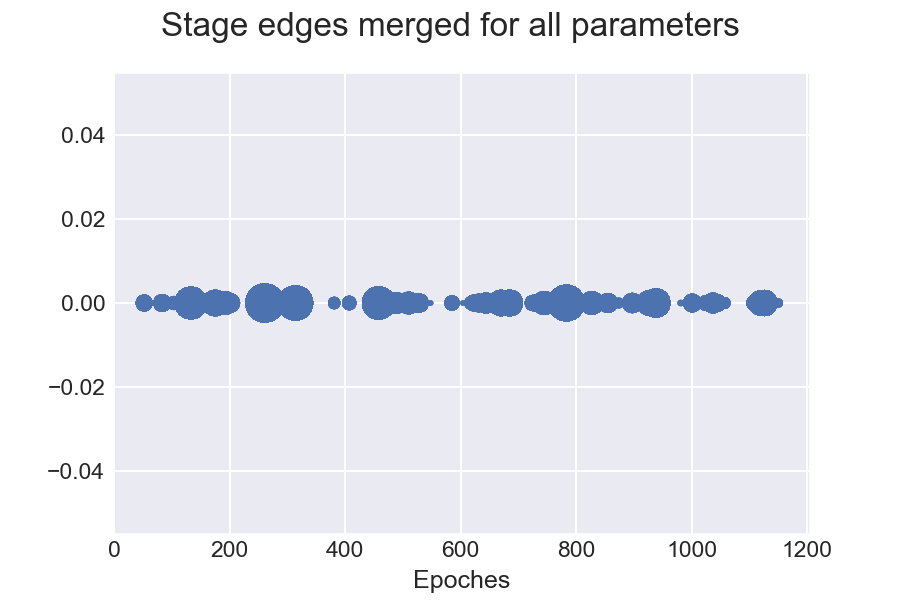

<IPython.core.display.Javascript object>


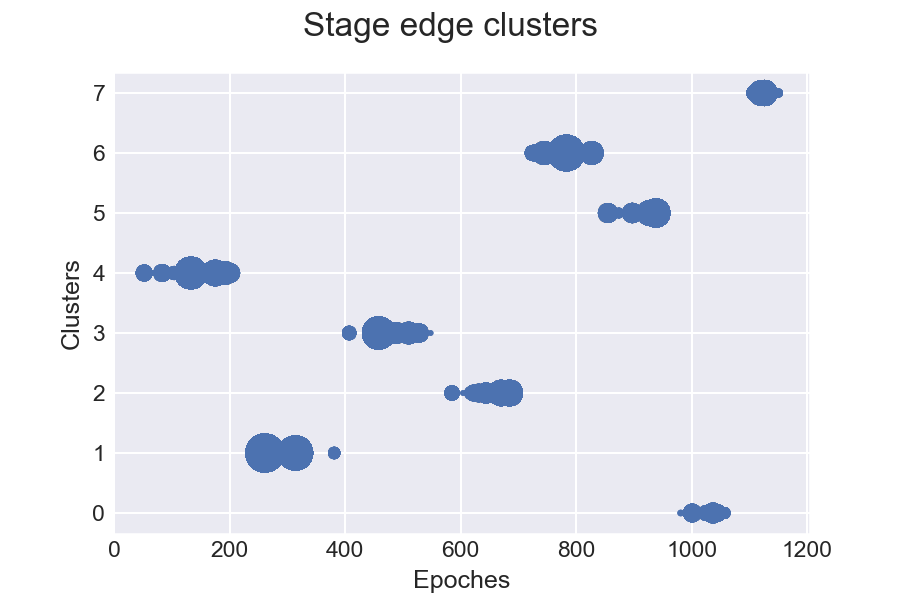

In [62]:
# Optimal number of clusters

n_stages = 9 # expert choise of result number of stages

st_len = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['St_len_min'].iloc[0]
k_nb = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['K_nb_max'].iloc[0]
n_cl = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['N_cl_max'].iloc[0]

# Cluster center type
cl_center_type = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['Cl_cen'].iloc[0]
print(cl_center_type)

# Stage boundary epoch numbers
st_edges_result = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['St_edges'].iloc[0]
#st_edges_result = [0, 92, 282, 492, 560, 666, 784, 857, 976, 1046] # results for m10
#st_edges_result = [0, 370, 526, 724, 1052, 1275, 1489, 1857, 2017] # results for m8
#st_edges_result = [0, 133, 261, 458, 685, 783, 938, 1037, 1126, 1180] # results for m3_2
print(st_edges_result)

st_edges_all = []
st_edges_list = []
st_edges_list += (df_st_edges[(df_st_edges['Len_min']==st_len) & (df_st_edges['K_neighb']<=k_nb) &
                  (df_st_edges['N_clusters']<=n_cl)]['St_edges'].tolist())
for _st_edges in st_edges_list:
    st_edges_all += _st_edges[1:-1].tolist()
st_edges_all = sorted(st_edges_all)
df_st_edges_all = pd.DataFrame(st_edges_all)
#print(st_edges_all)
            
# Clustering stage edges
cl_name = 'kmeans_edges_'+str(n_stages-1)+'_'+str(st_len)+'_'+str(k_nb)
cluster_method, df_st_edge_metrics = cq.apply_cluster_method(data=df_st_edges_all, cl_method=KMeans, 
                                                            name=cl_name, df_metrics=df_st_edge_metrics, 
                                                            n_clusters=n_stages-1, random_state=0)
edg_labels_all = cluster_method.labels_
   
# Plotting st_edges_all
x = st_edges_all
y = [0]*len(x)
s = [1.5*x.count(x[i]) for i in range(len(x))]
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x,y, s=s)
ax.set(xlabel='Epoches')
ax.tick_params(axis='both', labelsize=11, direction='in')
fig.suptitle('Stage edges merged for all parameters', fontsize=16)
plt.savefig(subj_dir_name+' Stage edges merged.png')

# Plotting clusters    
x = st_edges_all
y = cluster_method.labels_
s = [1.5*x.count(x[i]) for i in range(len(x))]
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x,y, s=s)
ax.set(xlabel='Epoches', ylabel='Clusters')
ax.tick_params(axis='both', labelsize=11, direction='in')
fig.suptitle('Stage edge clusters', fontsize=16)
plt.savefig(subj_dir_name+' Stage edge clusters.png')


In [63]:
# Find clustering statistic parameters (Main data)

df_st_edg_stats = pd.DataFrame(columns=['Cluster name', 'Median', 'Mean', 'Mode', 'Mode probability', 'Standard deviation', 
                                        'Median 0.95 confidence interval', 'Cluster size'])
st_clusters = []
for _st in range(n_stages-1):
    st_clusters.append([st_edges_all[i] for i in np.where(cluster_method.labels_ == _st)[0]])
    mode, count = sp.stats.mode(st_clusters[_st])
    conf_int_median = spr.median_confidence_interval(pd.Series(st_clusters[_st]), cutoff=0.95)
    
    new_row = {'Cluster name': 'Boundary cluster '+str(_st), 'Median': int(np.median(st_clusters[_st])), 'Mean': int(np.array(st_clusters[_st]).mean()), 'Mode': mode[0], 
               'Mode probability': count[0]/len(st_clusters[_st]), 'Standard deviation': int(np.array(st_clusters[_st]).std()), 
               'Median 0.95 confidence interval': conf_int_median, 'Cluster size': len(st_clusters[_st])}
    df_st_edg_stats = df_st_edg_stats.append(new_row, ignore_index = True)

df_st_edg_stats = df_st_edg_stats.sort_values('Median', ignore_index=True)

df_name = subj_dir_name + ' df_st_edg_stats.xlsx'
print(df_name)
display(df_st_edg_stats)
df_st_edg_stats.to_excel(df_name)


m03_2 df_st_edg_stats.xlsx


Cluster name Median  Mean  Mode  Mode probability Standard deviation  \
0  Boundary cluster 4    171   156   133              0.20                 41   
1  Boundary cluster 1    261   287   261              0.50                 31   
2  Boundary cluster 3    488   483   458              0.35                 32   
3  Boundary cluster 2    644   652   685              0.19                 29   
4  Boundary cluster 6    783   767   783              0.37                 33   
5  Boundary cluster 5    928   908   938              0.33                 32   
6  Boundary cluster 0   1037  1026  1037              0.26                 19   
7  Boundary cluster 7   1120  1122  1126              0.42                  7   

  Median 0.95 confidence interval Cluster size  
0                      (171, 175)          720  
1                      (261, 268)          417  
2                      (488, 488)          423  
3                      (644, 670)          471  
4                      (745, 783)          489  
5                      (928, 928)          338  
6                    (1025, 1037)          202  
7                    (1120, 1126)          208

In [64]:
# Main data
df_adj_st_metr = calc_stage_metr_noground(df_features, st_edges_result)
st_metr_silh = df_adj_st_metr['Silh'].to_numpy()
st_metr_calh = df_adj_st_metr['Cal-Har'].to_numpy()
st_metr_davb = df_adj_st_metr['Dav-Bold'].to_numpy()

st_dist_ward, st_dist_centr = spr.calc_stage_distances(df_features, st_edges_result)
df_adj_st_metr['Centr'] = st_dist_centr
df_adj_st_metr['Ward'] = st_dist_ward

display(df_adj_st_metr)

Stages  Silh  Cal-Har  Dav-Bold  Centr      Ward
0  St1_St2  0.06    15.56      3.90   9.95  6,458.93
1  St2_St3  0.20    82.08      1.87  17.68 24,241.15
2  St3_St4  0.06    29.04      3.58   9.34  9,209.57
3  St4_St5  0.11    33.73      2.76  13.93 13,287.25
4  St5_St6  0.04    13.51      4.06  10.00  6,002.51
5  St6_St7  0.10    32.17      2.61  14.87 13,366.18
6  St7_St8  0.12    28.48      2.49  15.61 11,414.05
7  St8_St9  0.11    22.40      2.32  16.78  9,463.99

<IPython.core.display.Javascript object>


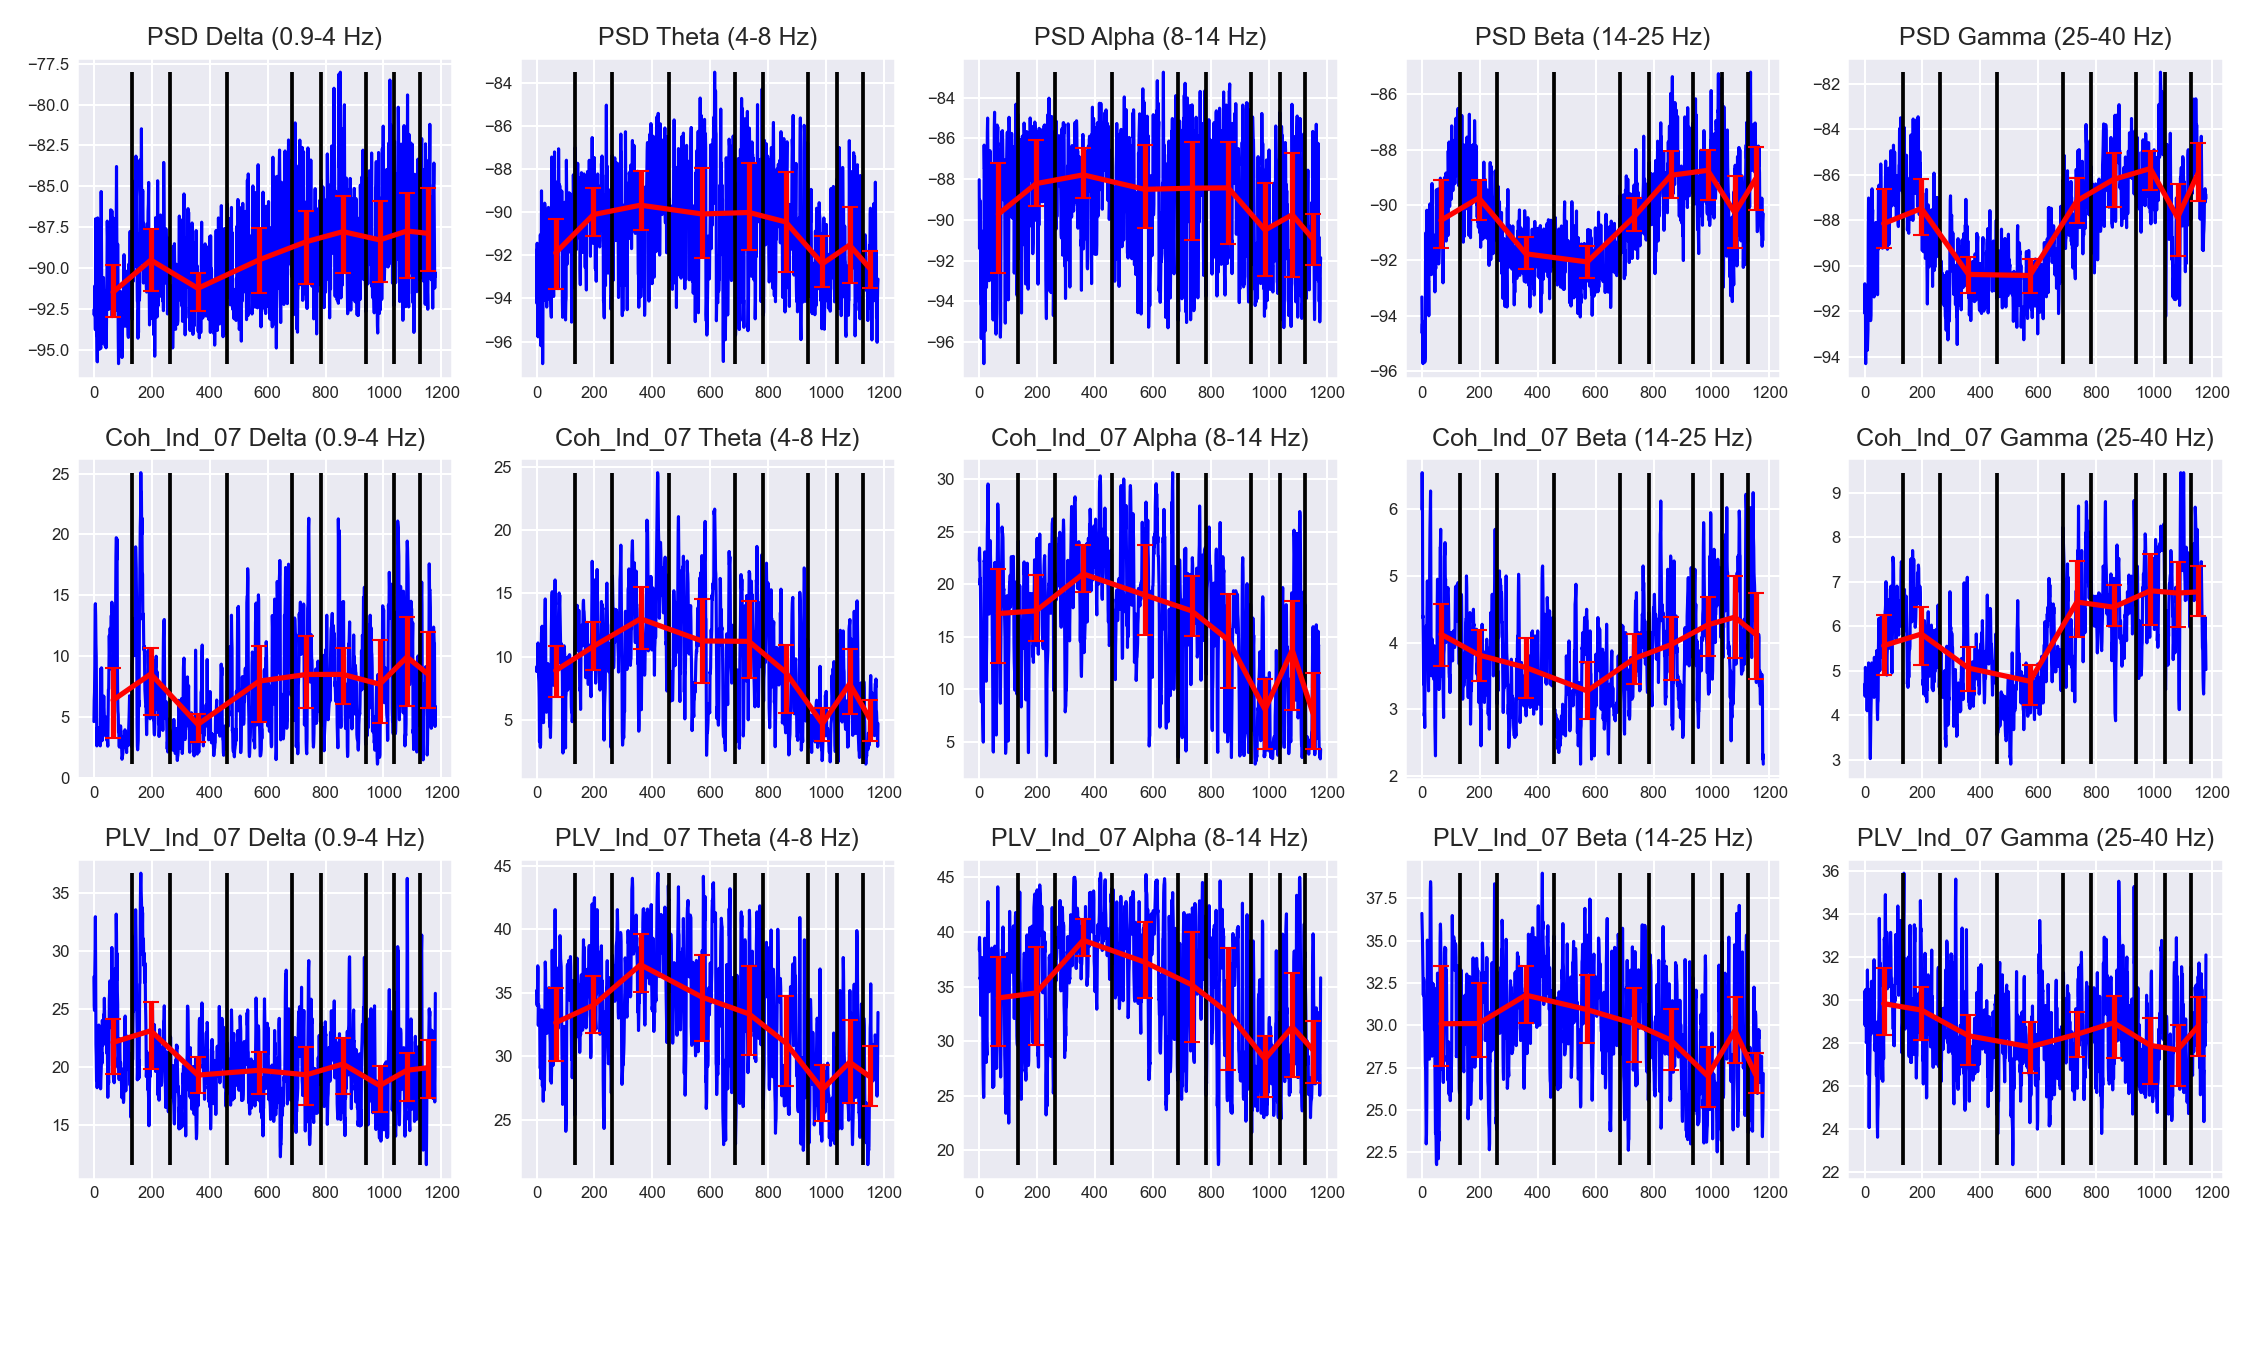

In [65]:
# Plotting overall PSD, Coherence and PLV with stage bounds

ind_rate = '07'

st_bands, st_labels = spr.form_stage_bands(st_edges_result, n_samples)

# Features DataFrames
df_ft_psd = df_ft_psd_all_db
df_cols = [col for col in df_ft_coh_ind_all.columns if (ind_rate in col)]
df_ft_coh = df_ft_coh_ind_all[df_cols]
df_cols = [col for col in df_ft_plv_ind_all.columns if (ind_rate in col)]
df_ft_plv = df_ft_plv_ind_all[df_cols]

# Initialize plots
n_cols = n_freq
n_rows = 3
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))
plt.subplots_adjust(left=0.02)

# PSD plots (1st row)
df_ft_clust = [df_ft_psd.iloc[smin:(smax+1), :] for (smin, smax, _) in st_bands]
df_ft_clust_stats = [df_ft_clust[_cl].describe() for _cl in range(n_stages)]
for i in range(n_freq):
    y = df_ft_psd.to_numpy()[:,i]  
    axs[0,i].plot(y, color='blue')
    axs[0,i].vlines(x=st_edges_result[1:-1], ymin=np.min(y), ymax=np.max(y), color='black', linewidth=1.8)
    axs[0,i].set_title("PSD "+ bands[i][2])
    axs[0,i].tick_params(axis='both', labelsize=8, direction='in')
    
    # Error bars (statistic plots)
    x_st = [(smin + smax)/2 for (smin, smax, _) in st_bands]
    y_st = [df_ft_clust_stats[_cl].loc['mean'][i] for _cl in range(n_stages)]
    yerr = np.array([df_ft_clust_stats[_cl].loc[['25%','75%']].to_numpy() for _cl in range(n_stages)])[:,:,i].transpose(1,0)
    yerr[0,:] = y_st - yerr[0,:]
    yerr[1,:] = yerr[1,:] - y_st
    #print(yerr)
    axs[0,i].errorbar(x_st, y_st, yerr, capsize=4, linewidth=2.5, color='red')
    
# Coherence plots (2nd row)
df_ft_clust = [df_ft_coh.iloc[smin:(smax+1), :] for (smin, smax, _) in st_bands]
df_ft_clust_stats = [df_ft_clust[_cl].describe() for _cl in range(n_stages)]
for i in range(n_freq):
    y = df_ft_coh.to_numpy()[:,i]
    axs[1,i].plot(y, color='blue')
    axs[1,i].vlines(x=st_edges_result[1:-1], ymin=np.min(y), ymax=np.max(y), color='black', linewidth=1.8)
    axs[1,i].set_title('Coh_Ind_'+ind_rate+' '+bands[i][2])
    axs[1,i].tick_params(axis='both', labelsize=8, direction='in')

    # Error bars (statistic plots)
    x_st = [(smin + smax)/2 for (smin, smax, _) in st_bands]
    y_st = [df_ft_clust_stats[_cl].loc['mean'][i] for _cl in range(n_stages)]
    yerr = np.array([df_ft_clust_stats[_cl].loc[['25%','75%']].to_numpy() for _cl in range(n_stages)])[:,:,i].transpose(1,0)
    yerr[0,:] = y_st - yerr[0,:]
    yerr[1,:] = yerr[1,:] - y_st
    #print(yerr)
    axs[1,i].errorbar(x_st, y_st, yerr, capsize=4, linewidth=2.5, color='red')   
    
# PLV plots (3rd row)
df_ft_clust = [df_ft_plv.iloc[smin:(smax+1), :] for (smin, smax, _) in st_bands]
df_ft_clust_stats = [df_ft_clust[_cl].describe() for _cl in range(n_stages)]
for i in range(n_freq):
    y = df_ft_plv.to_numpy()[:,i]
    axs[2,i].plot(y, color='blue')
    axs[2,i].vlines(x=st_edges_result[1:-1], ymin=np.min(y), ymax=np.max(y), color='black', linewidth=1.8)
    axs[2,i].set_title('PLV_Ind_'+ind_rate+' '+bands[i][2])
    axs[2,i].tick_params(axis='both', labelsize=8, direction='in')

    # Error bars (statistic plots)
    x_st = [(smin + smax)/2 for (smin, smax, _) in st_bands]
    y_st = [df_ft_clust_stats[_cl].loc['mean'][i] for _cl in range(n_stages)]
    yerr = np.array([df_ft_clust_stats[_cl].loc[['25%','75%']].to_numpy() for _cl in range(n_stages)])[:,:,i].transpose(1,0)
    yerr[0,:] = y_st - yerr[0,:]
    yerr[1,:] = yerr[1,:] - y_st
    #print(yerr)
    axs[2,i].errorbar(x_st, y_st, yerr, capsize=4, linewidth=2.5, color='red')       
    
plt.tight_layout(rect=[0,0.09,1,1])

#fig.suptitle('PSD in brain regions by spectrum')
plt.savefig(subj_dir_name + ' features in stages.png') 


# Results

In [70]:
# Initialization
df_features = df_ft_tot_pca
print(len(df_features.columns))


15
15


In [71]:
# Calculate stage distances & clustering quality metrics

# Main data
df_adj_st_metr = calc_stage_metr_noground(df_features, st_edges_result)
st_metr_silh = df_adj_st_metr['Silh'].to_numpy()
st_metr_calh = df_adj_st_metr['Cal-Har'].to_numpy()
st_metr_davb = df_adj_st_metr['Dav-Bold'].to_numpy()

st_dist_ward, st_dist_centr = spr.calc_stage_distances(df_features, st_edges_result)
df_adj_st_metr['Centr'] = st_dist_centr
df_adj_st_metr['Ward'] = st_dist_ward

# Max distance values for plotting
st_dist_centr_max = np.max(st_dist_centr)
st_dist_ward_max = np.max(st_dist_ward)
st_metr_silh_max = np.max(st_metr_silh)
st_metr_calh_max = np.max(st_metr_calh)
st_metr_davb_max = np.max(st_metr_davb)

print('Centr:', round(st_dist_centr_max,2), ' Silh:', round(st_metr_silh_max,2), ' Davb:', round(st_metr_davb_max,2), 
      ' Ward:', round(st_dist_ward_max,2), ' Calh:', round(st_metr_calh_max,2))
display(df_adj_st_metr)
display(df_adj_st_metr_surr)

Centr: 17.68  Silh: 0.2  Davb: 9.84  Ward: 24241.15  Calh: 82.08


Stages  Silh  Cal-Har  Dav-Bold  Centr      Ward
0  St1_St2  0.06    15.56      3.90   9.95  6,458.93
1  St2_St3  0.20    82.08      1.87  17.68 24,241.15
2  St3_St4  0.06    29.04      3.58   9.34  9,209.57
3  St4_St5  0.11    33.73      2.76  13.93 13,287.25
4  St5_St6  0.04    13.51      4.06  10.00  6,002.51
5  St6_St7  0.10    32.17      2.61  14.87 13,366.18
6  St7_St8  0.12    28.48      2.49  15.61 11,414.05
7  St8_St9  0.11    22.40      2.32  16.78  9,463.99

Stages  Silh  Cal-Har  Dav-Bold  Centr     Ward
0  St1_St2  0.00     3.73      7.69   5.44 1,770.69
1  St2_St3  0.02     5.41      5.57   7.29 2,376.96
2  St3_St4  0.00     3.21      8.06   5.20 1,536.96
3  St4_St5  0.01     2.51      9.84   4.47 1,285.57
4  St5_St6  0.04     7.36      5.25   7.76 3,294.59
5  St6_St7  0.05    14.61      3.81   9.80 5,513.76
6  St7_St8  0.04    17.27      3.90  10.36 7,791.68
7  St8_St9  0.03    11.97      5.20   8.15 5,787.43

## Main data

[141, 144, 220, 254, 105, 168, 106, 93, 56]


<IPython.core.display.Javascript object>


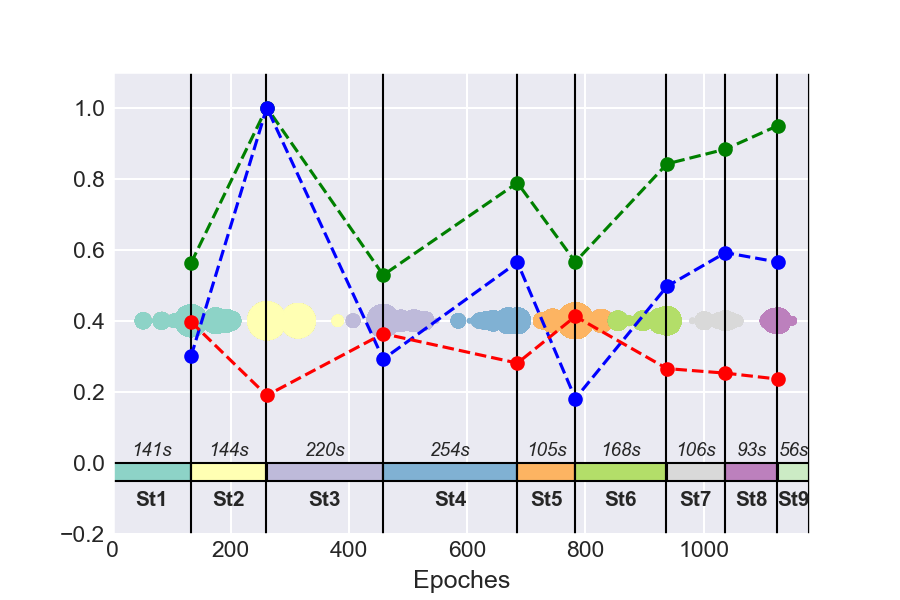

In [73]:
# Plotting stages, distances, silh between adjacent

df_features = df_ft_tot_pca
st_bands, st_labels = spr.form_stage_bands(st_edges_result, n_samples)
n_stages = len(st_bands)

# Sorting cluster labels for st_edges_all
#edg_labels_all = cluster_method.labels_
labels_uq = sorted(set(edg_labels_all), key=list(edg_labels_all).index)
edg_labels_sort = []
for _cl in range(len(labels_uq)):
    edg_labels_sort += [_cl for i in np.where(edg_labels_all == labels_uq[_cl])[0]]

# Getting time length of the stages
cluster_events = epochs_filt_rr.events.copy() # for m10 and m3
#cluster_events = epochs_filt_rr[:-2].events.copy() # for m8
cluster_events[:,2] = st_labels
time_bands = []
for i in range(n_stages):
    cl_samples = np.where(cluster_events[:,2] == i)[0]
    time_bands.append((cluster_events[cl_samples[0]][0], cluster_events[cl_samples[-1]][0], st_bands[i][2]))
st_time_len = [round((time_bands[i][1]-time_bands[i][0])/sampling_rate) for i in range(n_stages)]
print(st_time_len)

# Plotting stages
pal = plt.get_cmap('Set3')
#pal = plt.get_cmap('gist_ncar')

fig, ax = plt.subplots(figsize=(6,4))
for _st in range(n_stages):
    # Set x & y limits
    (ymin, ymax) = (-0.2, 1.1)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(0, n_samples)
    
    # Stages plot
    (x_start, x_end, st_name) = st_bands[_st]
    x = np.arange(x_start, x_end+1)
    y = np.full(len(x), 0)    
    event_label = 'N=%d' % (x_end-x_start+1)
    ax.add_patch(Rectangle((x_start, -0.05), x_end-x_start, 0.05, edgecolor = 'black', 
                           #facecolor = pal(_st/(n_stages-1)), fill=True, lw=1)) # for 9 stages
                           facecolor = pal(_st/(n_stages)), fill=True, lw=1)) # for 8 stages
    
    # Vertical lines (stage boundaries)
    ax.vlines(x_end, ymin=ymin, ymax=ymax, color='black', linewidth=1) # black lines
    #ax.vlines(x_end, ymin=ymin, ymax=ymax, color=pal(_st/(n_stages-1))) # colored lines
    
    # Background colors
    #ax.axvspan(x_start, x_end, alpha=0.3, color=pal(_st/(n_stages-1)))

    # Scatter plot
    x_sc = [st_edges_all[i] for i in range(len(st_edges_all)) if edg_labels_sort[i]==_st]
    y_sc = np.full(len(x_sc), 0.4)
    s = [1.5*x_sc.count(x_sc[i]) for i in range(len(x_sc))]
    #ax.scatter(x_sc, y_sc, s=s, color=pal(_st/(n_stages-1))) # for 9 stages
    ax.scatter(x_sc, y_sc, s=s, color=pal(_st/(n_stages))) # for 8 stages
    
    # Add text (st_name & st_length in sec)
    plt.text((x_start+x_end)/2, -0.12, st_name, fontsize=10, fontweight='bold', horizontalalignment='center')
    plt.text((x_start+x_end)/2, 0.02, str(st_time_len[_st])+'s', fontsize=9, fontstyle='italic', horizontalalignment='center')
    
# Adjacent stage distances (Centroid) & Silh coef 
x_dist = st_edges_result[1:-1]
y_centr = [_dist/st_dist_centr_max for _dist in st_dist_centr]
y_silh = [_dist/st_metr_silh_max for _dist in st_metr_silh]
#y_calh = [_dist/st_metr_calh_max for _dist in st_metr_calh]
y_davb = [_dist/st_metr_davb_max for _dist in st_metr_davb]
    
ax.plot(x_dist, y_centr, linestyle='--', marker='o', color='green', label='Centroid distance')
ax.plot(x_dist, y_silh, linestyle='--', marker='o', color='blue', label='Silhouette score')
#ax.plot(x_dist, y_calh, linestyle='--', marker='o', color='orange', label='Cal-Har metric')
ax.plot(x_dist, y_davb, linestyle='--', marker='o', color='red', label='Davies-Bouldin score')

ax.set(xlabel='Epoches')
ax.tick_params(axis='both', labelsize=11, direction='in')
plt.savefig(subj_dir_name + ' meditation stages.png')

#plt.tight_layout(rect=[-0.01,0.05,1,1])
#handles, labels = ax.get_legend_handles_labels()
#leg = fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=11, handlelength=4)# , mode='expand')


In [74]:
# Getting time length of the stages

st_names =['Stage '+str(i+1) for i in range(n_stages)]
df_st_time_len = pd.DataFrame(columns=['Parameters']+st_names)

time_bands = []
for i in range(n_stages):
    cl_samples = np.where(cluster_events[:,2] == i)[0]
    time_bands.append((cluster_events[cl_samples[0]][0], cluster_events[cl_samples[-1]][0], 'St'+str(i+1)))

# Start-end time
st_param_dict = dict([(st_names[i], (round(time_bands[i][0]/sampling_rate), round(time_bands[i][1]/sampling_rate))) 
                      for i in range(n_stages)])
new_row = {'Parameters': 'Start-end time, sec'}
new_row.update(st_param_dict)
df_st_time_len = df_st_time_len.append(new_row, ignore_index = True)

# Time length, sec
st_param_dict = dict([(st_names[i], str((time_bands[i][1]-time_bands[i][0])/sampling_rate)) for i in range(n_stages)])
new_row = {'Parameters': 'Time length, sec'}
new_row.update(st_param_dict)
df_st_time_len = df_st_time_len.append(new_row, ignore_index = True)

# Number of epochs, sec
st_param_dict = dict([(st_names[i], st_bands[i][1]-st_bands[i][0]+1) for i in range(n_stages)])
print(st_param_dict)
new_row = {'Parameters': 'Number of epochs'}
new_row.update(st_param_dict)
df_st_time_len = df_st_time_len.append(new_row, ignore_index = True)

print(time_bands)
print([((band[1]-band[0])/sampling_rate, band[2]) for band in time_bands])

display(df_st_time_len)    
df_st_time_len.to_excel(subj_dir_name + ' df_st_time_len.xlsx')


{'Stage 1': 133, 'Stage 2': 128, 'Stage 3': 197, 'Stage 4': 227, 'Stage 5': 98, 'Stage 6': 155, 'Stage 7': 99, 'Stage 8': 89, 'Stage 9': 54}
[(4250, 74750, 'St1'), (75750, 147750, 'St2'), (148250, 258250, 'St3'), (258750, 385750, 'St4'), (386250, 438750, 'St5'), (439250, 523250, 'St6'), (523750, 576750, 'St7'), (577250, 623750, 'St8'), (624250, 652250, 'St9')]
[(141.0, 'St1'), (144.0, 'St2'), (220.0, 'St3'), (254.0, 'St4'), (105.0, 'St5'), (168.0, 'St6'), (106.0, 'St7'), (93.0, 'St8'), (56.0, 'St9')]


Parameters   Stage 1     Stage 2     Stage 3     Stage 4  \
0  Start-end time, sec  (8, 150)  (152, 296)  (296, 516)  (518, 772)   
1     Time length, sec     141.0       144.0       220.0       254.0   
2     Number of epochs       133         128         197         227   

      Stage 5      Stage 6       Stage 7       Stage 8       Stage 9  
0  (772, 878)  (878, 1046)  (1048, 1154)  (1154, 1248)  (1248, 1304)  
1       105.0        168.0         106.0          93.0          56.0  
2          98          155            99            89            54

In [75]:
# DataFrame with stage distances (by adjacent pairs)

df_features = df_ft_tot_pca

# Forming DataFrame with distance values    
st_dist_names = ['St'+str(i)+'_St'+str(i+1) for i in range(1, n_stages)]
df_st_dist_pairs = pd.DataFrame(columns=['Method'] + st_dist_names)
#display(df_st_dist_pairs)
 
# Ward distances
st_dist_ward_dict = dict([(st_dist_names[i], st_dist_ward[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Ward distance'}
new_row.update(st_dist_ward_dict)
df_st_dist_pairs = df_st_dist_pairs.append(new_row, ignore_index = True)

# Centroid distances
st_dist_cen_dict = dict([(st_dist_names[i], st_dist_centr[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Centroid distance'}
new_row.update(st_dist_cen_dict)
df_st_dist_pairs = df_st_dist_pairs.append(new_row, ignore_index = True)

# Silh metrics
st_metr_silh_dict = dict([(st_dist_names[i], st_metr_silh[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Silhouette Coefficient'}
new_row.update(st_metr_silh_dict)
df_st_dist_pairs = df_st_dist_pairs.append(new_row, ignore_index = True)

# Cal-Har metrics
st_metr_calh_dict = dict([(st_dist_names[i], st_metr_calh[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Calinski-Harabasz Index'}
new_row.update(st_metr_calh_dict)
df_st_dist_pairs = df_st_dist_pairs.append(new_row, ignore_index = True)

# Dav-Bold metrics
st_metr_davb_dict = dict([(st_dist_names[i], st_metr_davb[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Davies-Bouldin Index'}
new_row.update(st_metr_davb_dict)
df_st_dist_pairs = df_st_dist_pairs.append(new_row, ignore_index = True)

display(df_st_dist_pairs)
df_st_dist_pairs.to_excel(subj_dir_name + ' df_st_dist_pairs.xlsx')

Method  St1_St2   St2_St3  St3_St4   St4_St5  St5_St6  \
0            Ward distance 6,458.93 24,241.15 9,209.57 13,287.25 6,002.51   
1        Centroid distance     9.95     17.68     9.34     13.93    10.00   
2   Silhouette Coefficient     0.06      0.20     0.06      0.11     0.04   
3  Calinski-Harabasz Index    15.56     82.08    29.04     33.73    13.51   
4     Davies-Bouldin Index     3.90      1.87     3.58      2.76     4.06   

    St6_St7   St7_St8  St8_St9  
0 13,366.18 11,414.05 9,463.99  
1     14.87     15.61    16.78  
2      0.10      0.12     0.11  
3     32.17     28.48    22.40  
4      2.61      2.49     2.32

In [76]:
# DataFrame with averaged cluster distances & metrics

subj_name = subj_dir_name

col_names = ['Subject', 'Center type', 'Ward dist', 'Centr dist', 'Silh Stage', 'Cal-Har Stage', 'Dav-Bold Stage', 
             'Silh Total', 'Cal-Har Total', 'Dav-Bold Total']
df_st_dist_total = pd.DataFrame(columns=col_names)

new_row = {'Subject': subj_name, 'Center type': cl_center_type}
n_pair_metr = len(df_st_dist_pairs)
n_head_col = len(new_row)
n_add_col = len(col_names)-n_head_col-n_pair_metr 

st_metr_val = [df_st_dist_pairs[df_st_dist_pairs.columns[1:]].iloc[r].mean() for r in range(n_pair_metr)]
new_row_add1 = dict([(col_names[r+n_head_col], st_metr_val[r]) for r in range(n_pair_metr)])
new_row.update(new_row_add1)

df = cq.cluster_metrics_noground(subj_name, df_features, st_labels)
new_row_add2 = dict([(col_names[r+n_head_col+n_pair_metr], df[df.columns[r+1]].iloc[0]) for r in range(n_add_col)])
new_row.update(new_row_add2)

df_st_dist_total = df_st_dist_total.append(new_row, ignore_index = True)

display(df_st_dist_total)
df_st_dist_total.to_excel(subj_dir_name + ' df_st_dist_total.xlsx')


Subject Center type  Ward dist  Centr dist  Silh Stage  Cal-Har Stage  \
0   m03_2        mode  11,680.45       13.52        0.10          32.12   

   Dav-Bold Stage  Silh Total  Cal-Har Total  Dav-Bold Total  
0            2.95       -0.02          67.26            4.68

# Save results

In [23]:
#st_edges_result = [0, 92, 282, 492, 560, 666, 784, 857, 976, 1046] # for m10
print(st_edges_result)

[0, 92, 282, 492, 560, 666, 784, 857, 976, 1046]


In [31]:
# Boundary epochs sample numbers and times
st_edges_res_samp = epochs_filt_rr[st_edges_result[:-1]].events[:,0]
print(st_edges_res_samp)
print(st_edges_result[:-1])


[  4950  44950 132150 228150 256550 304150 354150 386150 438950]
[0, 92, 282, 492, 560, 666, 784, 857, 976]


In [52]:
# Save clusterization results

# Clusterization
#df_st_edges.to_feather(os.path.join(ft_dir_path, 'df_st_edges.feather'))
#df_st_edges = pd.read_feather(os.path.join(ft_root_path, 'df_st_edges.feather'))

# Main data
np.savetxt(os.path.join(ft_dir_path, 'st_edges_result.txt'), st_edges_result)
np.savetxt(os.path.join(ft_dir_path, 'st_edges_res_samp.txt'), st_edges_res_samp)

print(st_edges_result)
print(st_edges_res_samp)


[  4250  75750 148250 258750 386250 439250 523750 577250 624250]
[0, 133, 261, 458, 685, 783, 938, 1037, 1126]
[0, 133, 261, 458, 685, 783, 938, 1037, 1126, 1180]
[  4250  75750 148250 258750 386250 439250 523750 577250 624250]
